In [53]:
import pandas as pd
import numpy as np
import nltk
import gc
import pyLDAvis.sklearn
from collections import Counter
from textblob import TextBlob
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet 
import string
%matplotlib inline
pd.options.mode.chained_assignment = None
pd.set_option('display.max_colwidth', 100)
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [54]:
df=pd.read_csv('../input/tinder-google-play-store-review/tinder_google_play_reviews.csv')

In [55]:
df.head(5)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
0,gp:AOqpTOG_9eJSnwoz0Kd8oTAk2zBntKZedjfWRP479-Ba8Les1Bx70PgMQ7RvOoTOgbjw8c4ywGocntM-uk3rUOU,David Allen,https://play-lh.googleusercontent.com/a-/AOh14GiF2auY-cikDzkKQF2nH7zUmdF6rIsYeaNFvi2e,"Basically pay to win, except unless you belong to the top 10% of men, there's no winning.",1,0,13.6.1,2022-05-14 05:47:07,NaN,NaN
1,gp:AOqpTOFw2mikSa_YS9uowlzKwoVnBbvjhobWhe1E22492nvX2kIQQ2rIDkuSMqt6maZLbzcb5VOLfAGYnH6osis,Gill Davinder,https://play-lh.googleusercontent.com/a/AATXAJwnjFyqLofpbuk4mvVLtlZkf9dtM-YNr3zgLZzu=mo,Really good app find to someone,5,0,12.15.0,2022-05-14 05:44:17,NaN,NaN
2,gp:AOqpTOFRFp5Elfb-L8NC4XBkCVN6hcoSJNhaBAnhaoRdoMZeHpIyst0fOlUNxr9RMCFk6HT3NbaqmP_SUA-MHN8,organic terrace garden ऑर्गेनिक गार्डन,https://play-lh.googleusercontent.com/a-/AOh14Gh3ebCB57A8iHKlfz4YWPcLppRi66gnClHnG1OnxQ,Very good,5,0,13.6.1,2022-05-14 05:35:14,NaN,NaN
3,gp:AOqpTOHels3YsoDGgfRx1emFiJR_b45BFEJxl92qZ_NFinPHBolGOVrRKiuLCYlUlklGnYKETxs0OuMRr3fdlRU,Howard Williams,https://play-lh.googleusercontent.com/a-/AOh14GhFjgkw2Qn7SqsIACNs55O995jrjjxzhjdTBkgfJ6I,Location location location,5,0,13.6.1,2022-05-14 05:33:55,NaN,NaN
4,gp:AOqpTOHicyEpcA38nUuwlyP_QWYAdJbEwTxq7tzjrP0Givlxku96FNDOTvu2t8K9jpRRPIkB6Vk36dFbOeli0Iw,Ceecee Ceecee,https://play-lh.googleusercontent.com/a/AATXAJzEWJXSEy6J0SK3DeHUxtpqR3Pr7FrHRITI_-Yv=mo,"Just made Tinder today, barely messaged people. Had no drama. Jumped on awhile later to see I ha...",1,0,NaN,2022-05-14 05:26:17,NaN,NaN


In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537047 entries, 0 to 537046
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   reviewId              537047 non-null  object
 1   userName              537042 non-null  object
 2   userImage             537047 non-null  object
 3   content               535704 non-null  object
 4   score                 537047 non-null  int64 
 5   thumbsUpCount         537047 non-null  int64 
 6   reviewCreatedVersion  427942 non-null  object
 7   at                    537047 non-null  object
 8   replyContent          47603 non-null   object
 9   repliedAt             47603 non-null   object
dtypes: int64(2), object(8)
memory usage: 41.0+ MB


In [57]:
df.columns

Index(['reviewId', 'userName', 'userImage', 'content', 'score',
       'thumbsUpCount', 'reviewCreatedVersion', 'at', 'replyContent',
       'repliedAt'],
      dtype='object')

In [58]:
numeric=['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df_num=df.select_dtypes(include=numeric)
df_num.columns

Index(['score', 'thumbsUpCount'], dtype='object')

In [59]:
df_cat=df.select_dtypes(include='object')
df_cat.head(3)

,reviewId,userName,userImage,content,reviewCreatedVersion,at,replyContent,repliedAt
0,gp:AOqpTOG_9eJSnwoz0Kd8oTAk2zBntKZedjfWRP479-Ba8Les1Bx70PgMQ7RvOoTOgbjw8c4ywGocntM-uk3rUOU,David Allen,https://play-lh.googleusercontent.com/a-/AOh14GiF2auY-cikDzkKQF2nH7zUmdF6rIsYeaNFvi2e,"Basically pay to win, except unless you belong to the top 10% of men, there's no winning.",13.6.1,2022-05-14 05:47:07,NaN,NaN
1,gp:AOqpTOFw2mikSa_YS9uowlzKwoVnBbvjhobWhe1E22492nvX2kIQQ2rIDkuSMqt6maZLbzcb5VOLfAGYnH6osis,Gill Davinder,https://play-lh.googleusercontent.com/a/AATXAJwnjFyqLofpbuk4mvVLtlZkf9dtM-YNr3zgLZzu=mo,Really good app find to someone,12.15.0,2022-05-14 05:44:17,NaN,NaN
2,gp:AOqpTOFRFp5Elfb-L8NC4XBkCVN6hcoSJNhaBAnhaoRdoMZeHpIyst0fOlUNxr9RMCFk6HT3NbaqmP_SUA-MHN8,organic terrace garden ऑर्गेनिक गार्डन,https://play-lh.googleusercontent.com/a-/AOh14Gh3ebCB57A8iHKlfz4YWPcLppRi66gnClHnG1OnxQ,Very good,13.6.1,2022-05-14 05:35:14,NaN,NaN


In [60]:
null=pd.DataFrame(df.isnull().sum(),columns=["Null Values"])
null["% Missing Values"]=(df.isna().sum()/len(df)*100)
null = null[null["% Missing Values"] > 0]
null.style.background_gradient(cmap='viridis',low =0.2,high=0.1) 

,Null Values,% Missing Values
userName,5,0.000931
content,1343,0.250071
reviewCreatedVersion,109105,20.315727
replyContent,489444,91.136158
repliedAt,489444,91.136158


In [61]:
df.dropna(subset=['content'], inplace=True)
df.drop(['userName', 'reviewCreatedVersion', 'replyContent', 'repliedAt'], axis=1, inplace=True)
null=pd.DataFrame(df.isnull().sum(),columns=["Null Values"])
null["% Missing Values"]=(df.isna().sum()/len(df)*100)
null = null[null["% Missing Values"] > 0]
null.style.background_gradient(cmap='viridis',low =0.2,high=0.1) 

,Null Values,% Missing Values


In [62]:
describeNum = df.describe(include =['float64', 'int64', 'float', 'int'])
describeNum.T.style.background_gradient(cmap='viridis',low=0.2,high=0.1)

,count,mean,std,min,25%,50%,75%,max
score,535704.000000,2.994323,1.759846,0.000000,1.000000,3.000000,5.000000,5.000000
thumbsUpCount,535704.000000,1.753384,27.327964,0.000000,0.000000,0.000000,0.000000,5503.000000


In [63]:
describeNumCat = df.describe(include=["O"])
describeNumCat.T.style.background_gradient(cmap='viridis',low=0.2,high=0.1)

,count,unique,top,freq
reviewId,535704,535704,gp:AOqpTOG_9eJSnwoz0Kd8oTAk2zBntKZedjfWRP479-Ba8Les1Bx70PgMQ7RvOoTOgbjw8c4ywGocntM-uk3rUOU,1
userImage,535704,499439,https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g,36266
content,535704,398483,Good,12328
at,535704,534881,2021-02-04 23:16:24,4


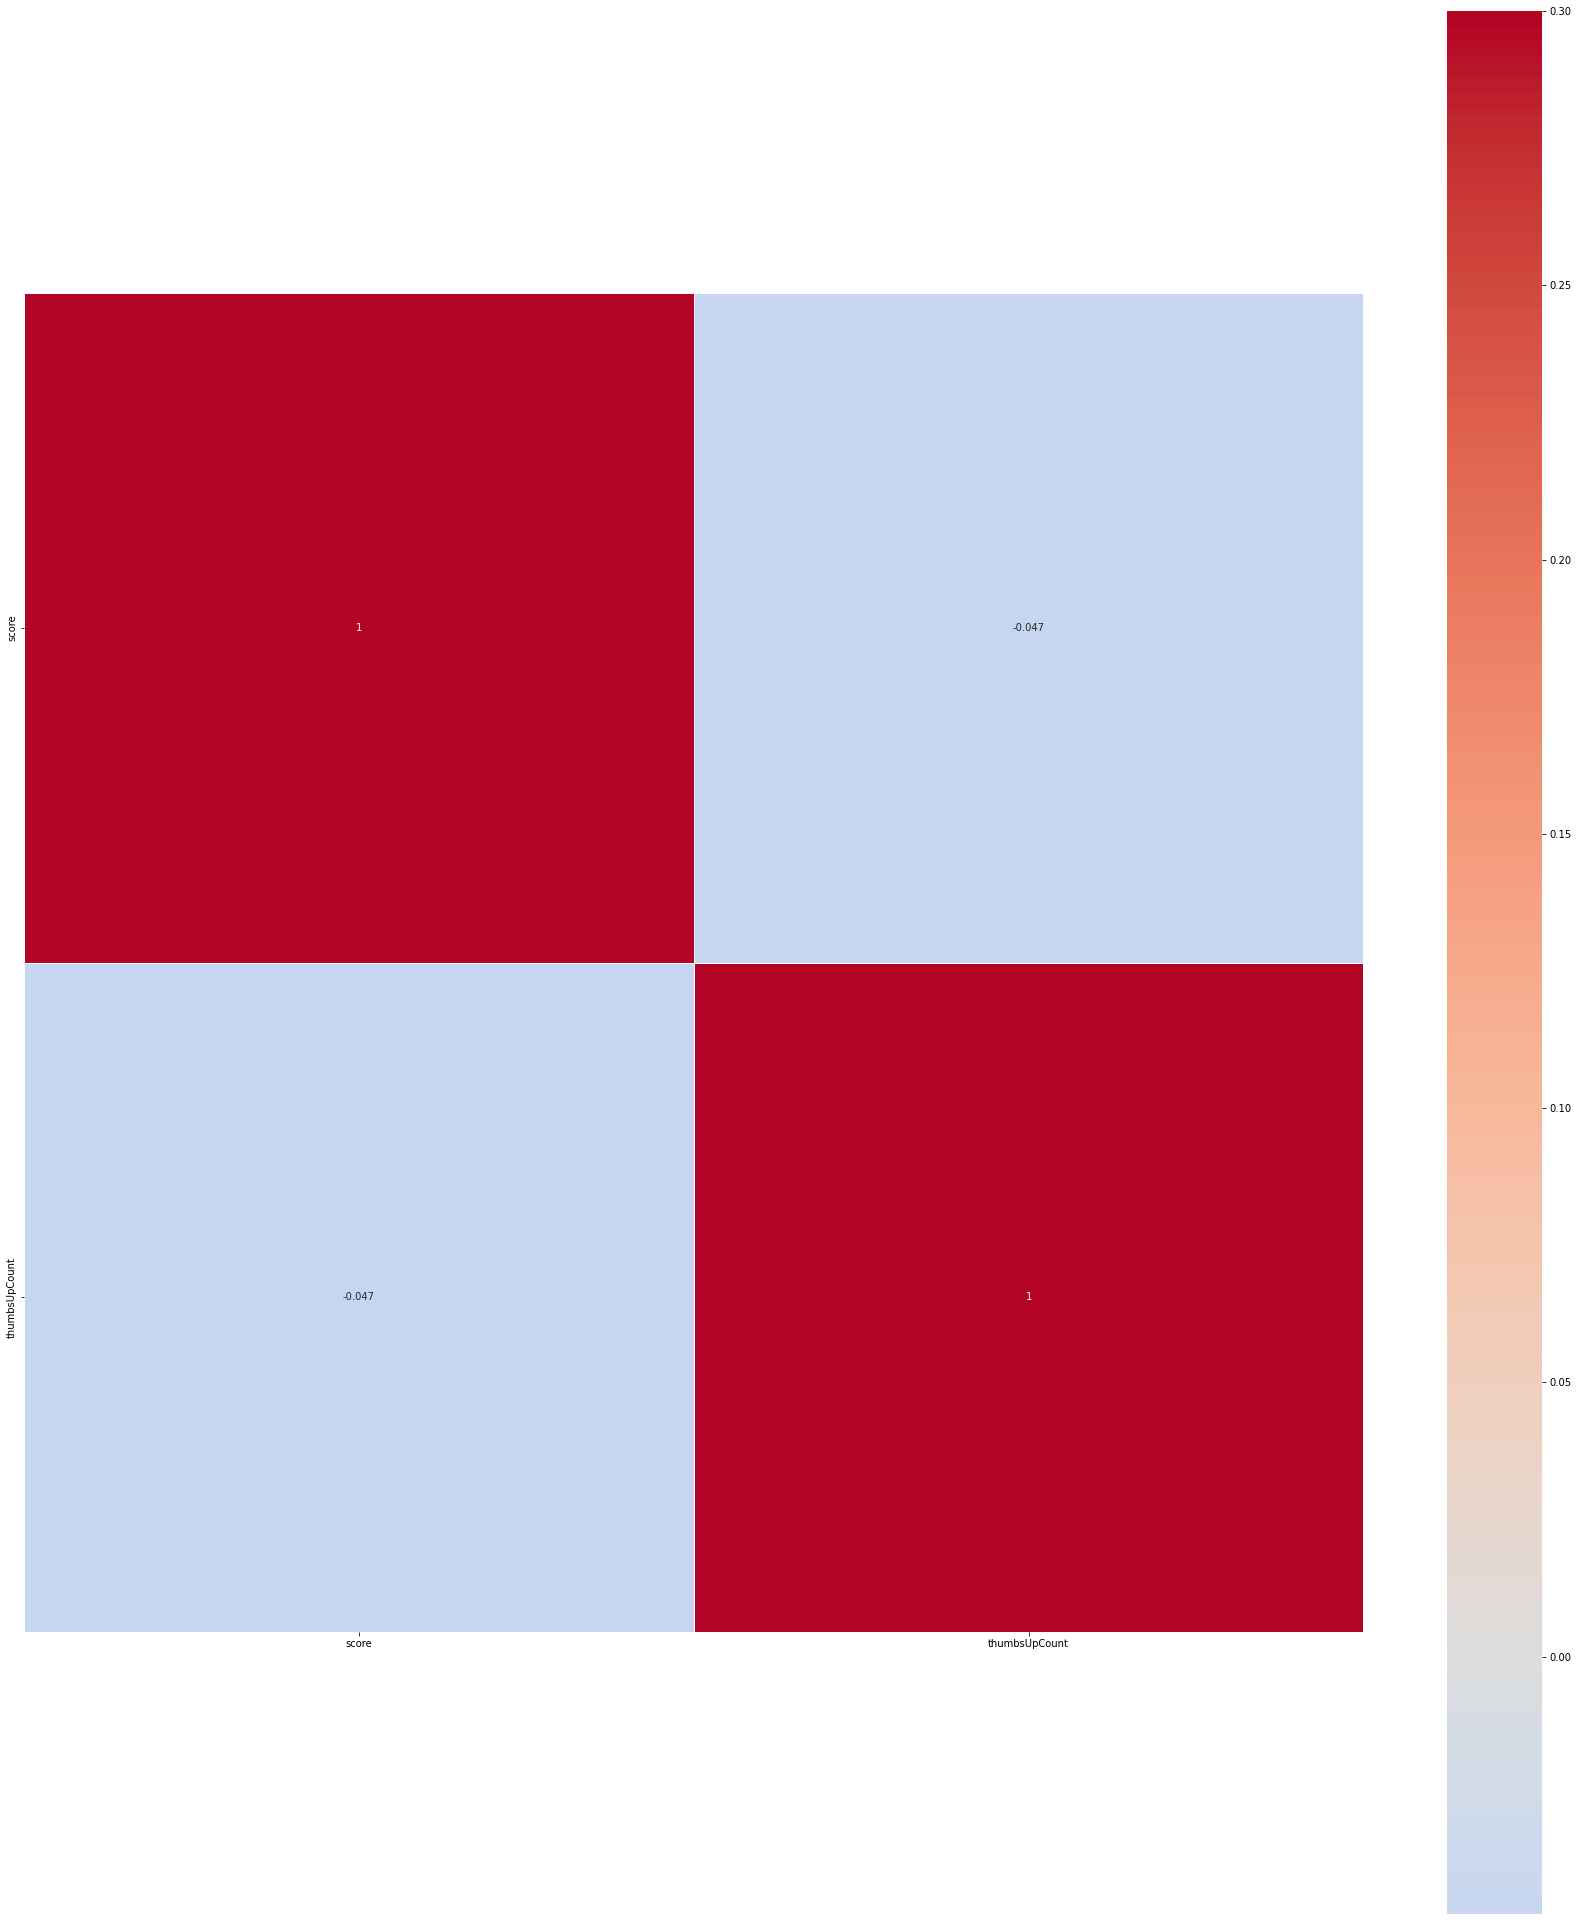

In [64]:
plt.figure(figsize=(30,35))
sns.heatmap(df.corr(),  cmap='coolwarm', vmax=.3, center=0,
            square=True, linewidths=.5,annot=True)
plt.show()

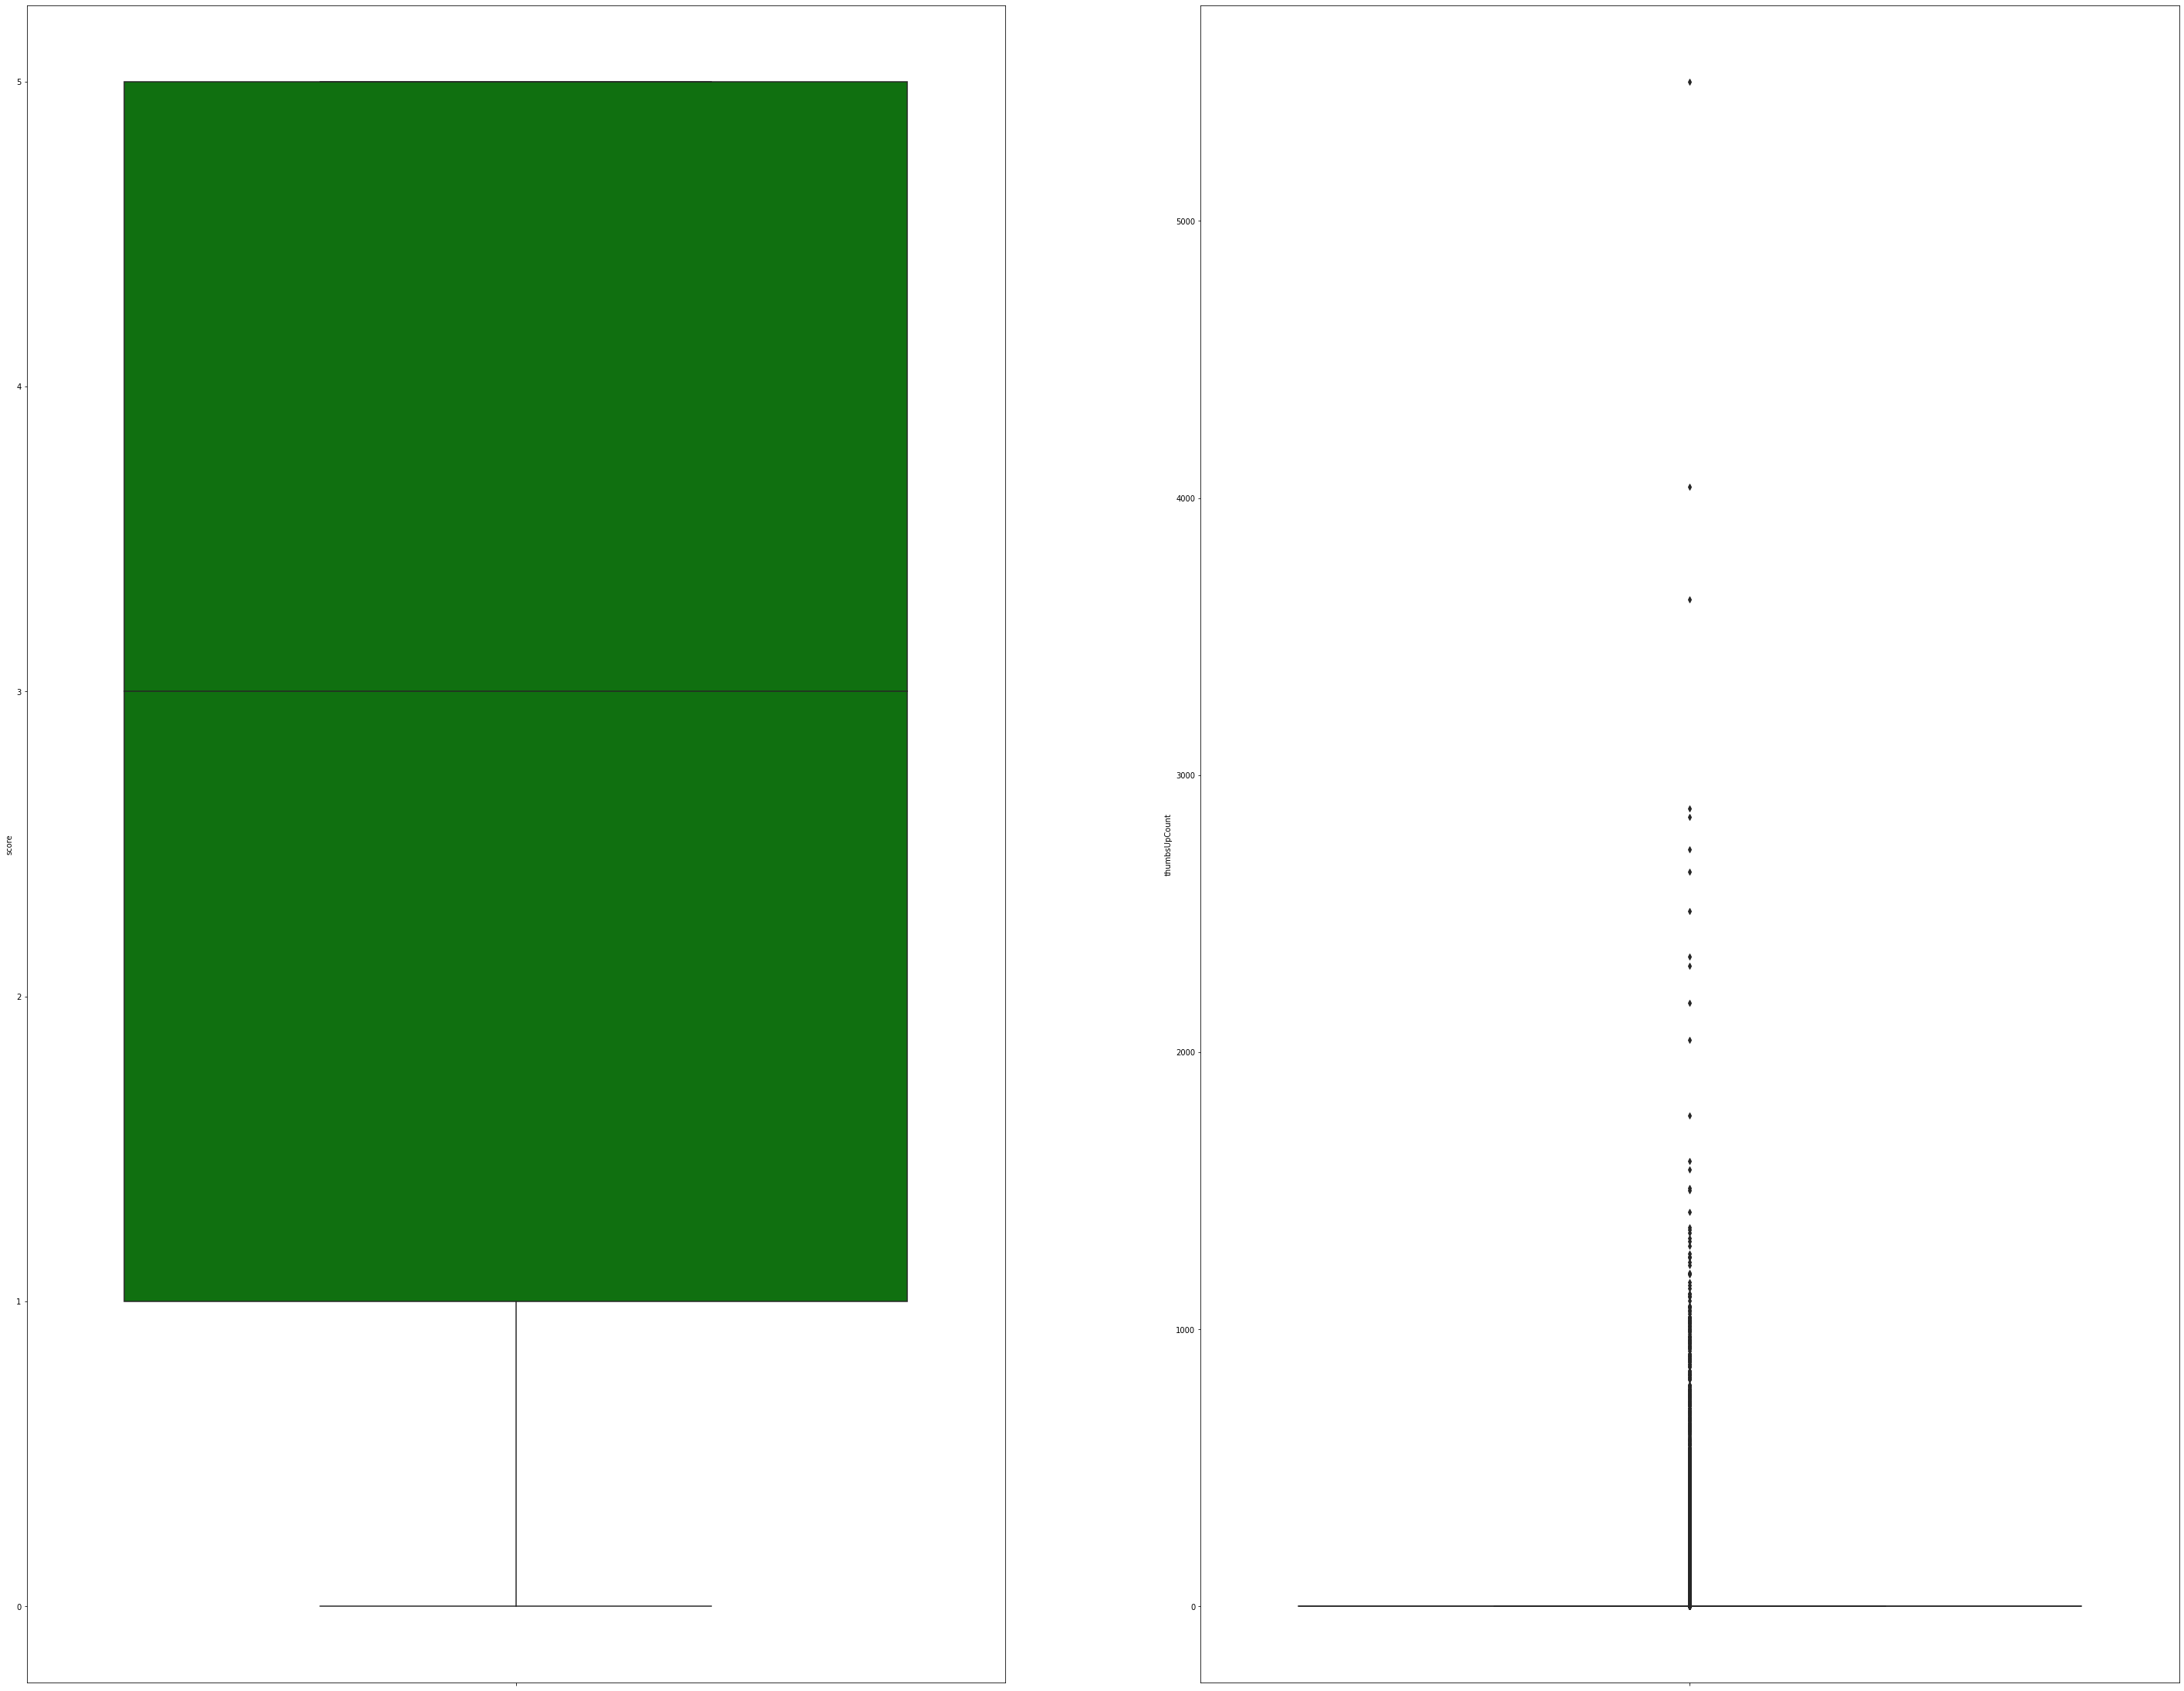

In [65]:
numeric=['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df_num=df.select_dtypes(include=numeric)
df_num.columns
featuresNum = df_num.columns

plt.figure(figsize=(50, 40))
for i in range(0, len(featuresNum)):
    plt.subplot(1, len(featuresNum), i+1)
    sns.boxplot(y=df[featuresNum[i]], color='green', orient='v')

In [66]:
puntucations = ['.','!','(',')','-','[',']','{','}',',',',',';',':','"','<','>','/','?','@','#','$','%','^','&','*','_','~']
df['content_words'] = [word_tokenize(l.translate(str.maketrans('', '', string.punctuation))) for l in df['content']]
df.head()
df['content_sents'] = [sent_tokenize(l) for l in df['content']]
df.head()

,reviewId,userImage,content,score,thumbsUpCount,at,content_words,content_sents
0,gp:AOqpTOG_9eJSnwoz0Kd8oTAk2zBntKZedjfWRP479-Ba8Les1Bx70PgMQ7RvOoTOgbjw8c4ywGocntM-uk3rUOU,https://play-lh.googleusercontent.com/a-/AOh14GiF2auY-cikDzkKQF2nH7zUmdF6rIsYeaNFvi2e,"Basically pay to win, except unless you belong to the top 10% of men, there's no winning.",1,0,2022-05-14 05:47:07,"[Basically, pay, to, win, except, unless, you, belong, to, the, top, 10, of, men, theres, no, wi...","[Basically pay to win, except unless you belong to the top 10% of men, there's no winning.]"
1,gp:AOqpTOFw2mikSa_YS9uowlzKwoVnBbvjhobWhe1E22492nvX2kIQQ2rIDkuSMqt6maZLbzcb5VOLfAGYnH6osis,https://play-lh.googleusercontent.com/a/AATXAJwnjFyqLofpbuk4mvVLtlZkf9dtM-YNr3zgLZzu=mo,Really good app find to someone,5,0,2022-05-14 05:44:17,"[Really, good, app, find, to, someone]",[Really good app find to someone]
2,gp:AOqpTOFRFp5Elfb-L8NC4XBkCVN6hcoSJNhaBAnhaoRdoMZeHpIyst0fOlUNxr9RMCFk6HT3NbaqmP_SUA-MHN8,https://play-lh.googleusercontent.com/a-/AOh14Gh3ebCB57A8iHKlfz4YWPcLppRi66gnClHnG1OnxQ,Very good,5,0,2022-05-14 05:35:14,"[Very, good]",[Very good]
3,gp:AOqpTOHels3YsoDGgfRx1emFiJR_b45BFEJxl92qZ_NFinPHBolGOVrRKiuLCYlUlklGnYKETxs0OuMRr3fdlRU,https://play-lh.googleusercontent.com/a-/AOh14GhFjgkw2Qn7SqsIACNs55O995jrjjxzhjdTBkgfJ6I,Location location location,5,0,2022-05-14 05:33:55,"[Location, location, location]",[Location location location]
4,gp:AOqpTOHicyEpcA38nUuwlyP_QWYAdJbEwTxq7tzjrP0Givlxku96FNDOTvu2t8K9jpRRPIkB6Vk36dFbOeli0Iw,https://play-lh.googleusercontent.com/a/AATXAJzEWJXSEy6J0SK3DeHUxtpqR3Pr7FrHRITI_-Yv=mo,"Just made Tinder today, barely messaged people. Had no drama. Jumped on awhile later to see I ha...",1,0,2022-05-14 05:26:17,"[Just, made, Tinder, today, barely, messaged, people, Had, no, drama, Jumped, on, awhile, later,...","[Just made Tinder today, barely messaged people., Had no drama., Jumped on awhile later to see I..."


In [67]:
content_lemmatize = []
for l in df['content_words']:
    lemmatize_str = ''
    for word in l:
        lemmatize_str = lemmatize_str + ' ' + lemmatizer.lemmatize(word)
    content_lemmatize.append(lemmatize_str)
        
df['content_lemmatize'] = content_lemmatize
content_lemmatize_stopwords_remove = []
for l in df['content_words']:
    lemmatize_str = ''
    for word in l:
        if word in stop_words:
            continue
        lemmatize_str = lemmatize_str + ' ' + lemmatizer.lemmatize(word)
    content_lemmatize_stopwords_remove.append(lemmatize_str)
        
df['content_lemmatize_stopwords_remove'] = content_lemmatize_stopwords_remove
df.head(20)

,reviewId,userImage,content,score,thumbsUpCount,at,content_words,content_sents,content_lemmatize,content_lemmatize_stopwords_remove
0,gp:AOqpTOG_9eJSnwoz0Kd8oTAk2zBntKZedjfWRP479-Ba8Les1Bx70PgMQ7RvOoTOgbjw8c4ywGocntM-uk3rUOU,https://play-lh.googleusercontent.com/a-/AOh14GiF2auY-cikDzkKQF2nH7zUmdF6rIsYeaNFvi2e,"Basically pay to win, except unless you belong to the top 10% of men, there's no winning.",1,0,2022-05-14 05:47:07,"[Basically, pay, to, win, except, unless, you, belong, to, the, top, 10, of, men, theres, no, wi...","[Basically pay to win, except unless you belong to the top 10% of men, there's no winning.]",Basically pay to win except unless you belong to the top 10 of men there no winning,Basically pay win except unless belong top 10 men there winning
1,gp:AOqpTOFw2mikSa_YS9uowlzKwoVnBbvjhobWhe1E22492nvX2kIQQ2rIDkuSMqt6maZLbzcb5VOLfAGYnH6osis,https://play-lh.googleusercontent.com/a/AATXAJwnjFyqLofpbuk4mvVLtlZkf9dtM-YNr3zgLZzu=mo,Really good app find to someone,5,0,2022-05-14 05:44:17,"[Really, good, app, find, to, someone]",[Really good app find to someone],Really good app find to someone,Really good app find someone
2,gp:AOqpTOFRFp5Elfb-L8NC4XBkCVN6hcoSJNhaBAnhaoRdoMZeHpIyst0fOlUNxr9RMCFk6HT3NbaqmP_SUA-MHN8,https://play-lh.googleusercontent.com/a-/AOh14Gh3ebCB57A8iHKlfz4YWPcLppRi66gnClHnG1OnxQ,Very good,5,0,2022-05-14 05:35:14,"[Very, good]",[Very good],Very good,Very good
3,gp:AOqpTOHels3YsoDGgfRx1emFiJR_b45BFEJxl92qZ_NFinPHBolGOVrRKiuLCYlUlklGnYKETxs0OuMRr3fdlRU,https://play-lh.googleusercontent.com/a-/AOh14GhFjgkw2Qn7SqsIACNs55O995jrjjxzhjdTBkgfJ6I,Location location location,5,0,2022-05-14 05:33:55,"[Location, location, location]",[Location location location],Location location location,Location location location
4,gp:AOqpTOHicyEpcA38nUuwlyP_QWYAdJbEwTxq7tzjrP0Givlxku96FNDOTvu2t8K9jpRRPIkB6Vk36dFbOeli0Iw,https://play-lh.googleusercontent.com/a/AATXAJzEWJXSEy6J0SK3DeHUxtpqR3Pr7FrHRITI_-Yv=mo,"Just made Tinder today, barely messaged people. Had no drama. Jumped on awhile later to see I ha...",1,0,2022-05-14 05:26:17,"[Just, made, Tinder, today, barely, messaged, people, Had, no, drama, Jumped, on, awhile, later,...","[Just made Tinder today, barely messaged people., Had no drama., Jumped on awhile later to see I...",Just made Tinder today barely messaged people Had no drama Jumped on awhile later to see I have...,Just made Tinder today barely messaged people Had drama Jumped awhile later see I banned Tinder...
5,gp:AOqpTOG0sLKsnxLFwpPA7TaoTzLi4YtABVIKCis7xmBzLWps4NksXNxviajWFrB53OCIGgcfe8uBvpn3S35Yq28,https://play-lh.googleusercontent.com/a-/AOh14GhryrsQ192fp26bf4ZO38D69fC5IfGRU9L38uko,Fake app,1,0,2022-05-14 05:17:44,"[Fake, app]",[Fake app],Fake app,Fake app
6,gp:AOqpTOHETHGndQ19e3k3RyC0xjkUt22ZzizDFtQq55L5yNk0m4DkOl-gQH0GbE7VjN5LqhnQxIGMLSQPD6KP0qw,https://play-lh.googleusercontent.com/a-/AOh14GjQBwRVF9Kq_XfH-j1L6ftHBYESe9UMwzSDL29UeA,"dejen de bloquear mi cuenta, gracias con odio",1,0,2022-05-14 04:57:37,"[dejen, de, bloquear, mi, cuenta, gracias, con, odio]","[dejen de bloquear mi cuenta, gracias con odio]",dejen de bloquear mi cuenta gracias con odio,dejen de bloquear mi cuenta gracias con odio
7,gp:AOqpTOFPmhJl4GYoUI4JOcFjgaW98dua9M34JD5okOg0cwflIiIDVjot22Ig0ux1bip2GIo-pssbYGHdIwjX-aI,https://play-lh.googleusercontent.com/a-/AOh14GgWAyJGcalGAtXwJcFsYg5P4FC5Um6oRWHipZb0jA,Many fake profiles around. My previous account blocked without any reason. I had an argument wit...,1,0,2022-05-14 04:42:12,"[Many, fake, profiles, around, My, previous, account, blocked, without, any, reason, I, had, an,...","[Many fake profiles around., My previous account blocked without any reason., I had an argument ...",Many fake profile around My previous account blocked without any reason I had an argument with ...,Many fake profile around My previous account blocked without reason I argument one match probab...
8,gp:AOqpTOFFP_CBlsCWddNlltePwWdnU2TPPTMrDaJOfKIjkshDGj2s6mxJmfodI71ByavmKH7eIn-7rVYpT4TBGYc,https://play-lh.googleuserconten

In [68]:
df['sentiment_stopwords'] = df['content_lemmatize'].apply(lambda x: TextBlob(x).sentiment.polarity)
df.head()

,reviewId,userImage,content,score,thumbsUpCount,at,content_words,content_sents,content_lemmatize,content_lemmatize_stopwords_remove,sentiment_stopwords
0,gp:AOqpTOG_9eJSnwoz0Kd8oTAk2zBntKZedjfWRP479-Ba8Les1Bx70PgMQ7RvOoTOgbjw8c4ywGocntM-uk3rUOU,https://play-lh.googleusercontent.com/a-/AOh14GiF2auY-cikDzkKQF2nH7zUmdF6rIsYeaNFvi2e,"Basically pay to win, except unless you belong to the top 10% of men, there's no winning.",1,0,2022-05-14 05:47:07,"[Basically, pay, to, win, except, unless, you, belong, to, the, top, 10, of, men, theres, no, wi...","[Basically pay to win, except unless you belong to the top 10% of men, there's no winning.]",Basically pay to win except unless you belong to the top 10 of men there no winning,Basically pay win except unless belong top 10 men there winning,0.350000
1,gp:AOqpTOFw2mikSa_YS9uowlzKwoVnBbvjhobWhe1E22492nvX2kIQQ2rIDkuSMqt6maZLbzcb5VOLfAGYnH6osis,https://play-lh.googleusercontent.com/a/AATXAJwnjFyqLofpbuk4mvVLtlZkf9dtM-YNr3zgLZzu=mo,Really good app find to someone,5,0,2022-05-14 05:44:17,"[Really, good, app, find, to, someone]",[Really good app find to someone],Really good app find to someone,Really good app find someone,0.700000
2,gp:AOqpTOFRFp5Elfb-L8NC4XBkCVN6hcoSJNhaBAnhaoRdoMZeHpIyst0fOlUNxr9RMCFk6HT3NbaqmP_SUA-MHN8,https://play-lh.googleusercontent.com/a-/AOh14Gh3ebCB57A8iHKlfz4YWPcLppRi66gnClHnG1OnxQ,Very good,5,0,2022-05-14 05:35:14,"[Very, good]",[Very good],Very good,Very good,0.910000
3,gp:AOqpTOHels3YsoDGgfRx1emFiJR_b45BFEJxl92qZ_NFinPHBolGOVrRKiuLCYlUlklGnYKETxs0OuMRr3fdlRU,https://play-lh.googleusercontent.com/a-/AOh14GhFjgkw2Qn7SqsIACNs55O995jrjjxzhjdTBkgfJ6I,Location location location,5,0,2022-05-14 05:33:55,"[Location, location, location]",[Location location location],Location location location,Location location location,0.000000
4,gp:AOqpTOHicyEpcA38nUuwlyP_QWYAdJbEwTxq7tzjrP0Givlxku96FNDOTvu2t8K9jpRRPIkB6Vk36dFbOeli0Iw,https://play-lh.googleusercontent.com/a/AATXAJzEWJXSEy6J0SK3DeHUxtpqR3Pr7FrHRITI_-Yv=mo,"Just made Tinder today, barely messaged people. Had no drama. Jumped on awhile later to see I ha...",1,0,2022-05-14 05:26:17,"[Just, made, Tinder, today, barely, messaged, people, Had, no, drama, Jumped, on, awhile, later,...","[Just made Tinder today, barely messaged people., Had no drama., Jumped on awhile later to see I...",Just made Tinder today barely messaged people Had no drama Jumped on awhile later to see I have...,Just made Tinder today barely messaged people Had drama Jumped awhile later see I banned Tinder...,0.016667


In [69]:
df['sentiment_stopwords'] = df['content_lemmatize'].apply(lambda x: TextBlob(x).sentiment.polarity)
df.head()

,reviewId,userImage,content,score,thumbsUpCount,at,content_words,content_sents,content_lemmatize,content_lemmatize_stopwords_remove,sentiment_stopwords
0,gp:AOqpTOG_9eJSnwoz0Kd8oTAk2zBntKZedjfWRP479-Ba8Les1Bx70PgMQ7RvOoTOgbjw8c4ywGocntM-uk3rUOU,https://play-lh.googleusercontent.com/a-/AOh14GiF2auY-cikDzkKQF2nH7zUmdF6rIsYeaNFvi2e,"Basically pay to win, except unless you belong to the top 10% of men, there's no winning.",1,0,2022-05-14 05:47:07,"[Basically, pay, to, win, except, unless, you, belong, to, the, top, 10, of, men, theres, no, wi...","[Basically pay to win, except unless you belong to the top 10% of men, there's no winning.]",Basically pay to win except unless you belong to the top 10 of men there no winning,Basically pay win except unless belong top 10 men there winning,0.350000
1,gp:AOqpTOFw2mikSa_YS9uowlzKwoVnBbvjhobWhe1E22492nvX2kIQQ2rIDkuSMqt6maZLbzcb5VOLfAGYnH6osis,https://play-lh.googleusercontent.com/a/AATXAJwnjFyqLofpbuk4mvVLtlZkf9dtM-YNr3zgLZzu=mo,Really good app find to someone,5,0,2022-05-14 05:44:17,"[Really, good, app, find, to, someone]",[Really good app find to someone],Really good app find to someone,Really good app find someone,0.700000
2,gp:AOqpTOFRFp5Elfb-L8NC4XBkCVN6hcoSJNhaBAnhaoRdoMZeHpIyst0fOlUNxr9RMCFk6HT3NbaqmP_SUA-MHN8,https://play-lh.googleusercontent.com/a-/AOh14Gh3ebCB57A8iHKlfz4YWPcLppRi66gnClHnG1OnxQ,Very good,5,0,2022-05-14 05:35:14,"[Very, good]",[Very good],Very good,Very good,0.910000
3,gp:AOqpTOHels3YsoDGgfRx1emFiJR_b45BFEJxl92qZ_NFinPHBolGOVrRKiuLCYlUlklGnYKETxs0OuMRr3fdlRU,https://play-lh.googleusercontent.com/a-/AOh14GhFjgkw2Qn7SqsIACNs55O995jrjjxzhjdTBkgfJ6I,Location location location,5,0,2022-05-14 05:33:55,"[Location, location, location]",[Location location location],Location location location,Location location location,0.000000
4,gp:AOqpTOHicyEpcA38nUuwlyP_QWYAdJbEwTxq7tzjrP0Givlxku96FNDOTvu2t8K9jpRRPIkB6Vk36dFbOeli0Iw,https://play-lh.googleusercontent.com/a/AATXAJzEWJXSEy6J0SK3DeHUxtpqR3Pr7FrHRITI_-Yv=mo,"Just made Tinder today, barely messaged people. Had no drama. Jumped on awhile later to see I ha...",1,0,2022-05-14 05:26:17,"[Just, made, Tinder, today, barely, messaged, people, Had, no, drama, Jumped, on, awhile, later,...","[Just made Tinder today, barely messaged people., Had no drama., Jumped on awhile later to see I...",Just made Tinder today barely messaged people Had no drama Jumped on awhile later to see I have...,Just made Tinder today barely messaged people Had drama Jumped awhile later see I banned Tinder...,0.016667


In [70]:
df['sentiment_without_stopwords'] = df['content_lemmatize_stopwords_remove'].apply(lambda x: TextBlob(x).sentiment.polarity)
df.head()

,reviewId,userImage,content,score,thumbsUpCount,at,content_words,content_sents,content_lemmatize,content_lemmatize_stopwords_remove,sentiment_stopwords,sentiment_without_stopwords
0,gp:AOqpTOG_9eJSnwoz0Kd8oTAk2zBntKZedjfWRP479-Ba8Les1Bx70PgMQ7RvOoTOgbjw8c4ywGocntM-uk3rUOU,https://play-lh.googleusercontent.com/a-/AOh14GiF2auY-cikDzkKQF2nH7zUmdF6rIsYeaNFvi2e,"Basically pay to win, except unless you belong to the top 10% of men, there's no winning.",1,0,2022-05-14 05:47:07,"[Basically, pay, to, win, except, unless, you, belong, to, the, top, 10, of, men, theres, no, wi...","[Basically pay to win, except unless you belong to the top 10% of men, there's no winning.]",Basically pay to win except unless you belong to the top 10 of men there no winning,Basically pay win except unless belong top 10 men there winning,0.350000,0.600
1,gp:AOqpTOFw2mikSa_YS9uowlzKwoVnBbvjhobWhe1E22492nvX2kIQQ2rIDkuSMqt6maZLbzcb5VOLfAGYnH6osis,https://play-lh.googleusercontent.com/a/AATXAJwnjFyqLofpbuk4mvVLtlZkf9dtM-YNr3zgLZzu=mo,Really good app find to someone,5,0,2022-05-14 05:44:17,"[Really, good, app, find, to, someone]",[Really good app find to someone],Really good app find to someone,Really good app find someone,0.700000,0.700
2,gp:AOqpTOFRFp5Elfb-L8NC4XBkCVN6hcoSJNhaBAnhaoRdoMZeHpIyst0fOlUNxr9RMCFk6HT3NbaqmP_SUA-MHN8,https://play-lh.googleusercontent.com/a-/AOh14Gh3ebCB57A8iHKlfz4YWPcLppRi66gnClHnG1OnxQ,Very good,5,0,2022-05-14 05:35:14,"[Very, good]",[Very good],Very good,Very good,0.910000,0.910
3,gp:AOqpTOHels3YsoDGgfRx1emFiJR_b45BFEJxl92qZ_NFinPHBolGOVrRKiuLCYlUlklGnYKETxs0OuMRr3fdlRU,https://play-lh.googleusercontent.com/a-/AOh14GhFjgkw2Qn7SqsIACNs55O995jrjjxzhjdTBkgfJ6I,Location location location,5,0,2022-05-14 05:33:55,"[Location, location, location]",[Location location location],Location location location,Location location location,0.000000,0.000
4,gp:AOqpTOHicyEpcA38nUuwlyP_QWYAdJbEwTxq7tzjrP0Givlxku96FNDOTvu2t8K9jpRRPIkB6Vk36dFbOeli0Iw,https://play-lh.googleusercontent.com/a/AATXAJzEWJXSEy6J0SK3DeHUxtpqR3Pr7FrHRITI_-Yv=mo,"Just made Tinder today, barely messaged people. Had no drama. Jumped on awhile later to see I ha...",1,0,2022-05-14 05:26:17,"[Just, made, Tinder, today, barely, messaged, people, Had, no, drama, Jumped, on, awhile, later,...","[Just made Tinder today, barely messaged people., Had no drama., Jumped on awhile later to see I...",Just made Tinder today barely messaged people Had no drama Jumped on awhile later to see I have...,Just made Tinder today barely messaged people Had drama Jumped awhile later see I banned Tinder...,0.016667,0.025


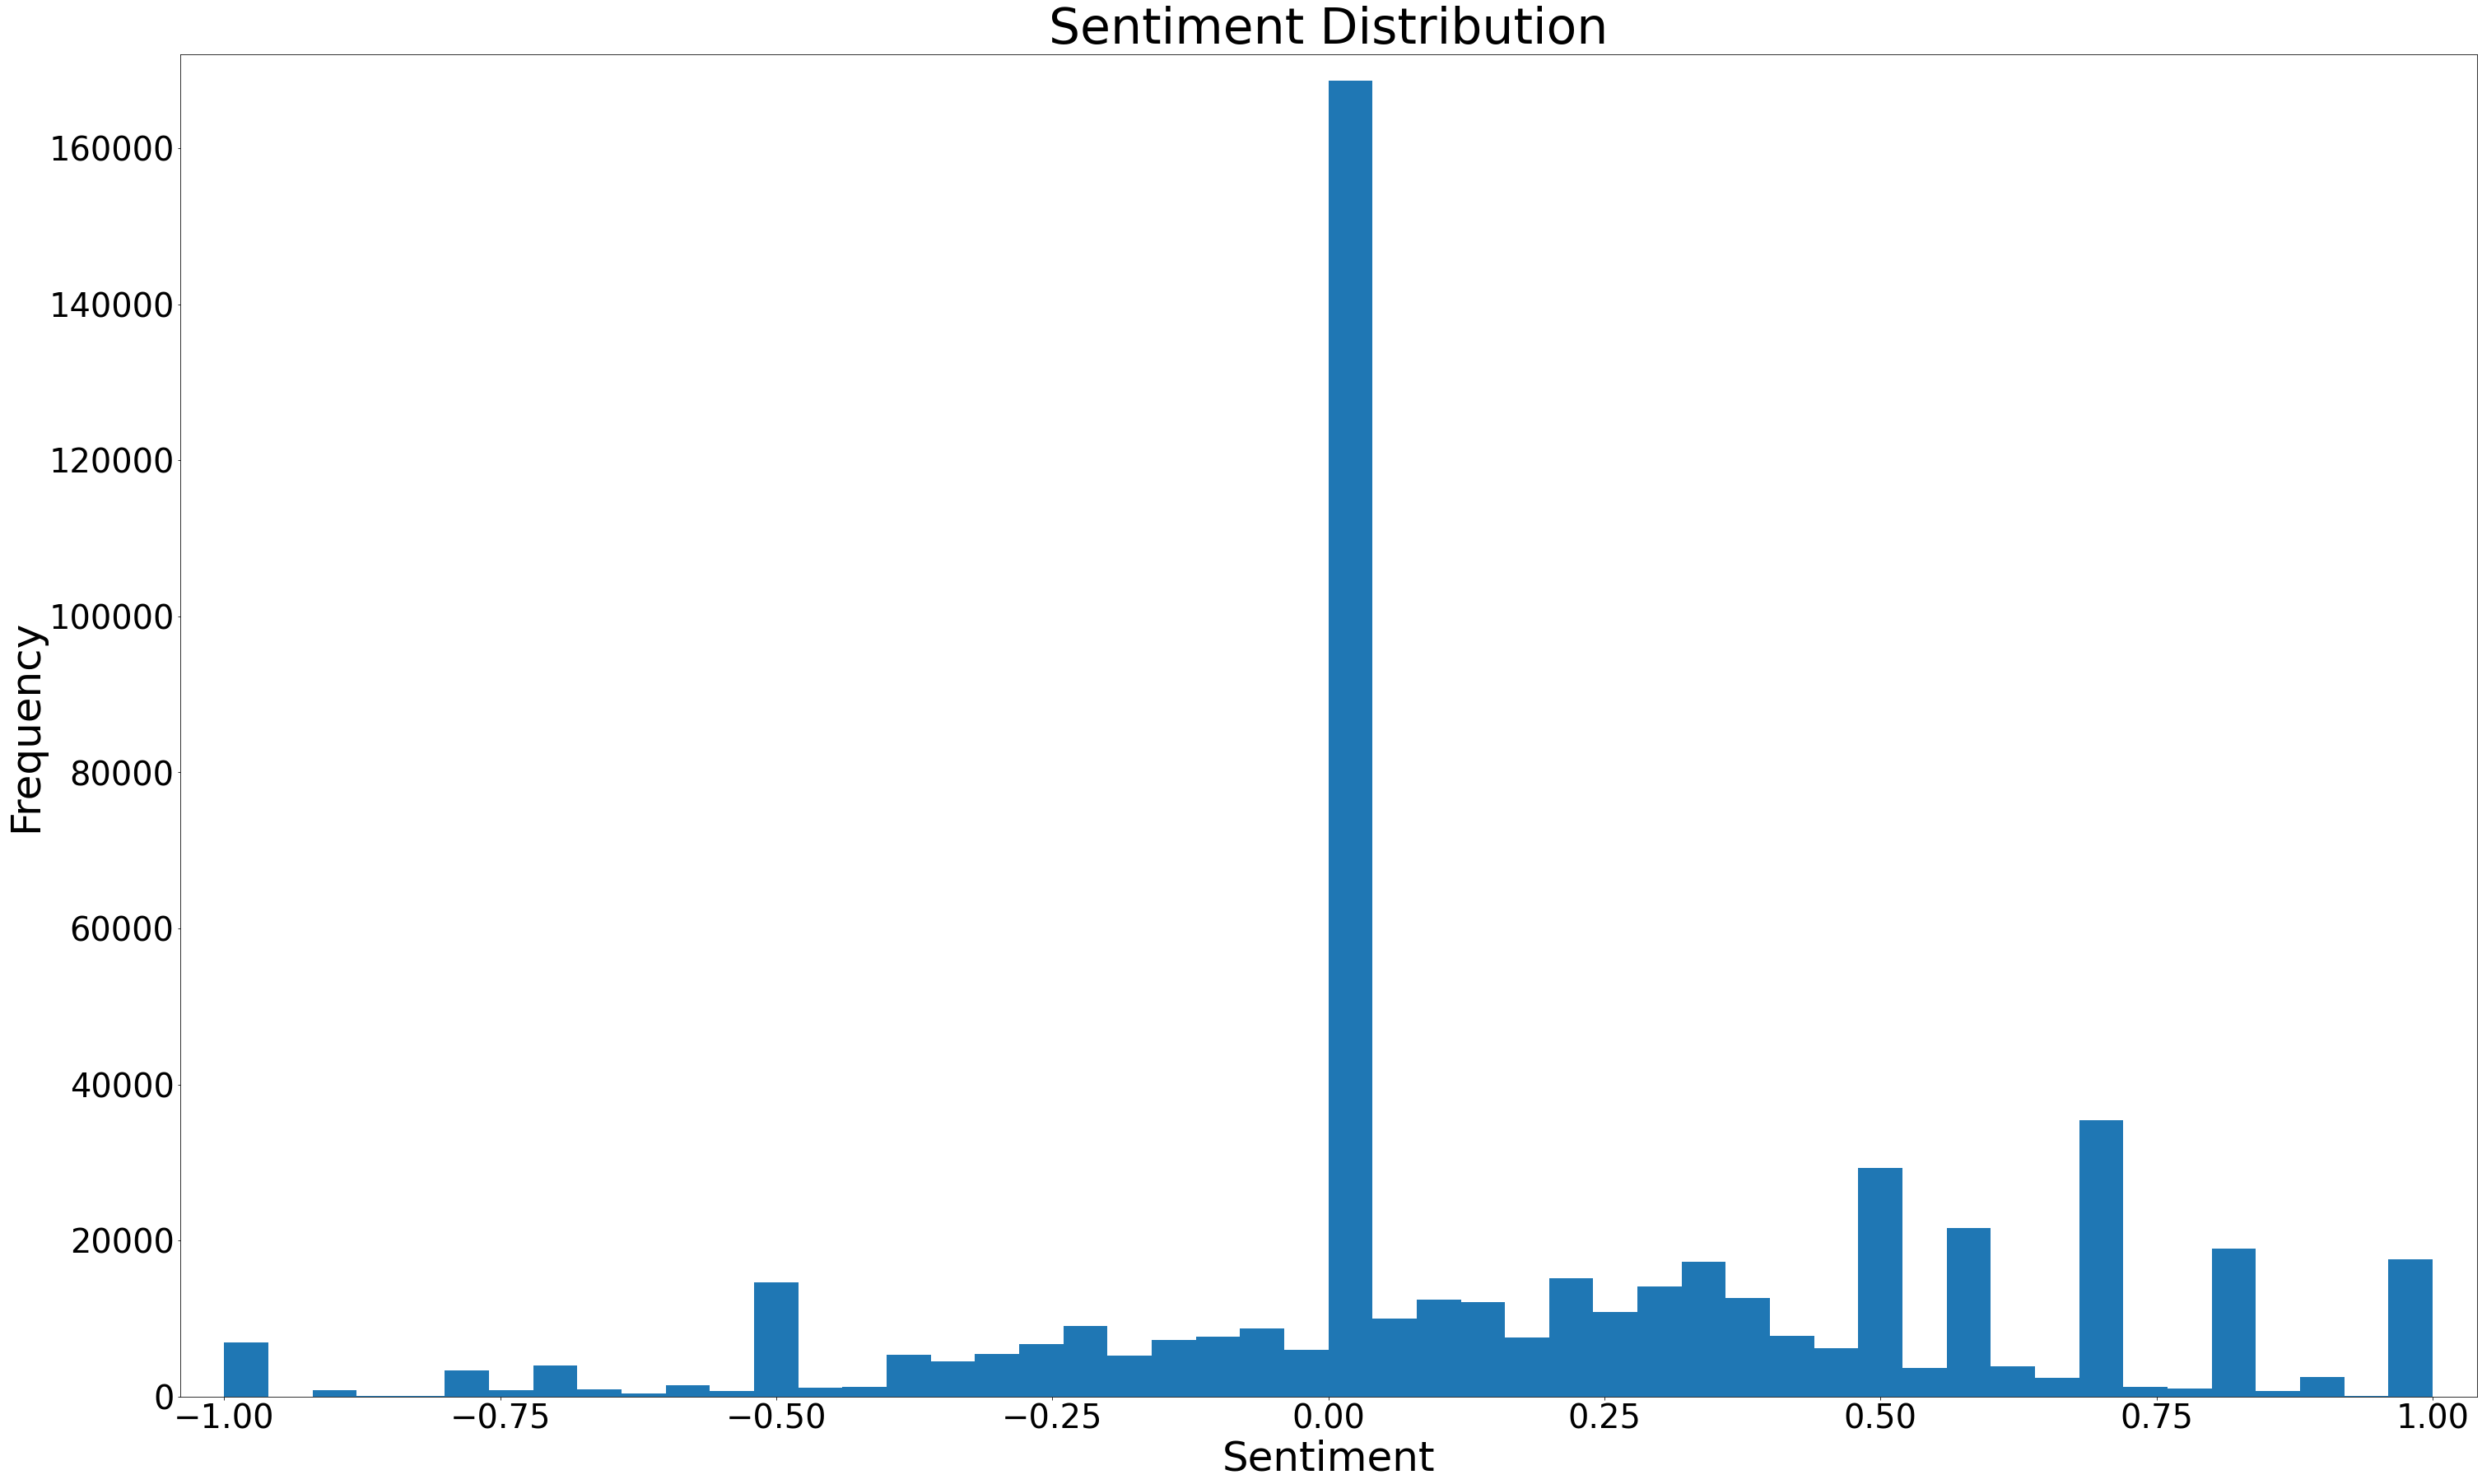

In [71]:
plt.figure(figsize=(50,30))
plt.margins(0.02)
plt.xlabel('Sentiment', fontsize=50)
plt.xticks(fontsize=40)
plt.ylabel('Frequency', fontsize=50)
plt.yticks(fontsize=40)
plt.hist(df['sentiment_without_stopwords'], bins=50)
plt.title('Sentiment Distribution', fontsize=60)
plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5')])

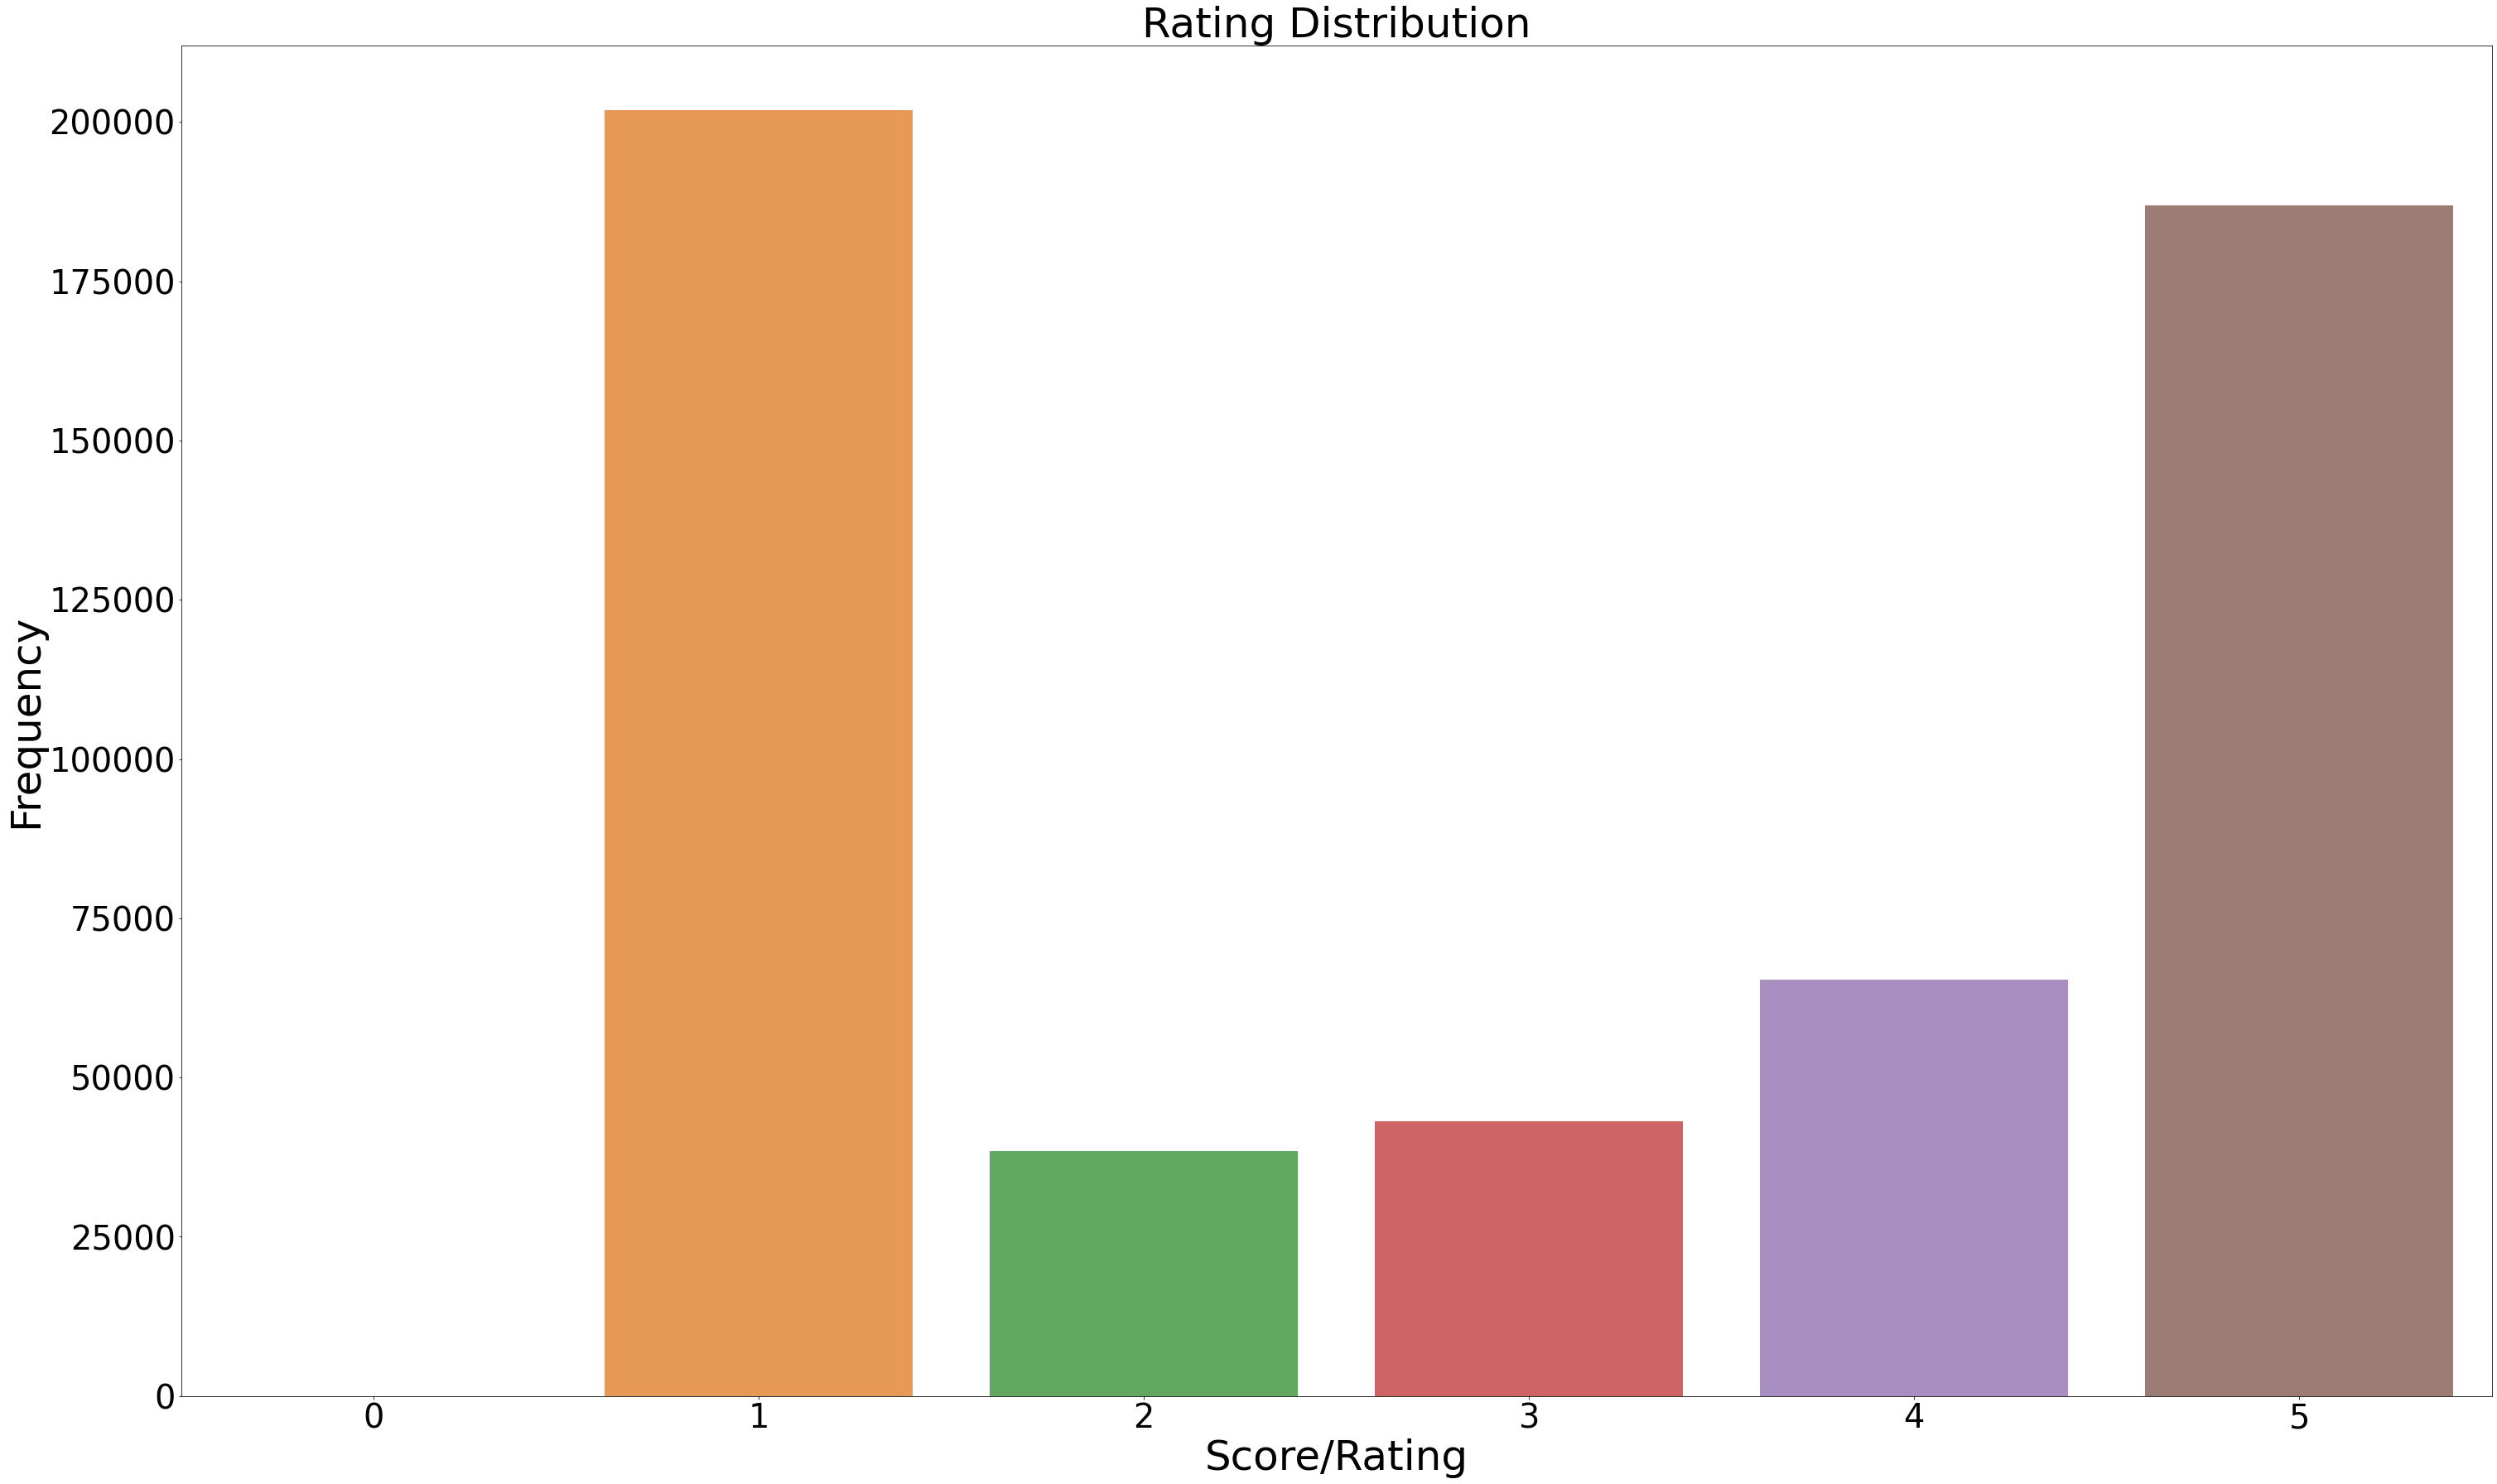

In [72]:
x_rating = df.score.value_counts()
y_rating = x_rating.sort_index()
plt.figure(figsize=(50,30))
sns.barplot(x_rating.index, x_rating.values, alpha=0.8)
plt.title("Rating Distribution", fontsize=50)
plt.ylabel('Frequency', fontsize=50)
plt.yticks(fontsize=40)
plt.xlabel('Score/Rating', fontsize=50)
plt.xticks(fontsize=40)

<AxesSubplot:title={'center':'Percentage of Ratings/Score'}, ylabel='score'>

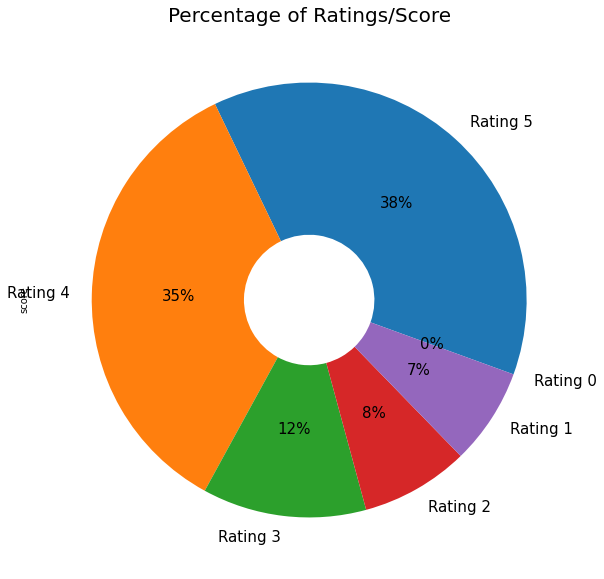

In [73]:
plt.figure(figsize=(30,10))
plt.title('Percentage of Ratings/Score', fontsize=20)
df.score.value_counts().plot(kind='pie', labels=['Rating 5', 'Rating 4', 'Rating 3', 'Rating 2', 'Rating 1', 'Rating 0'],
                              wedgeprops=dict(width=.7), autopct='%1.0f%%', startangle= -20, 
                              textprops={'fontsize': 15})

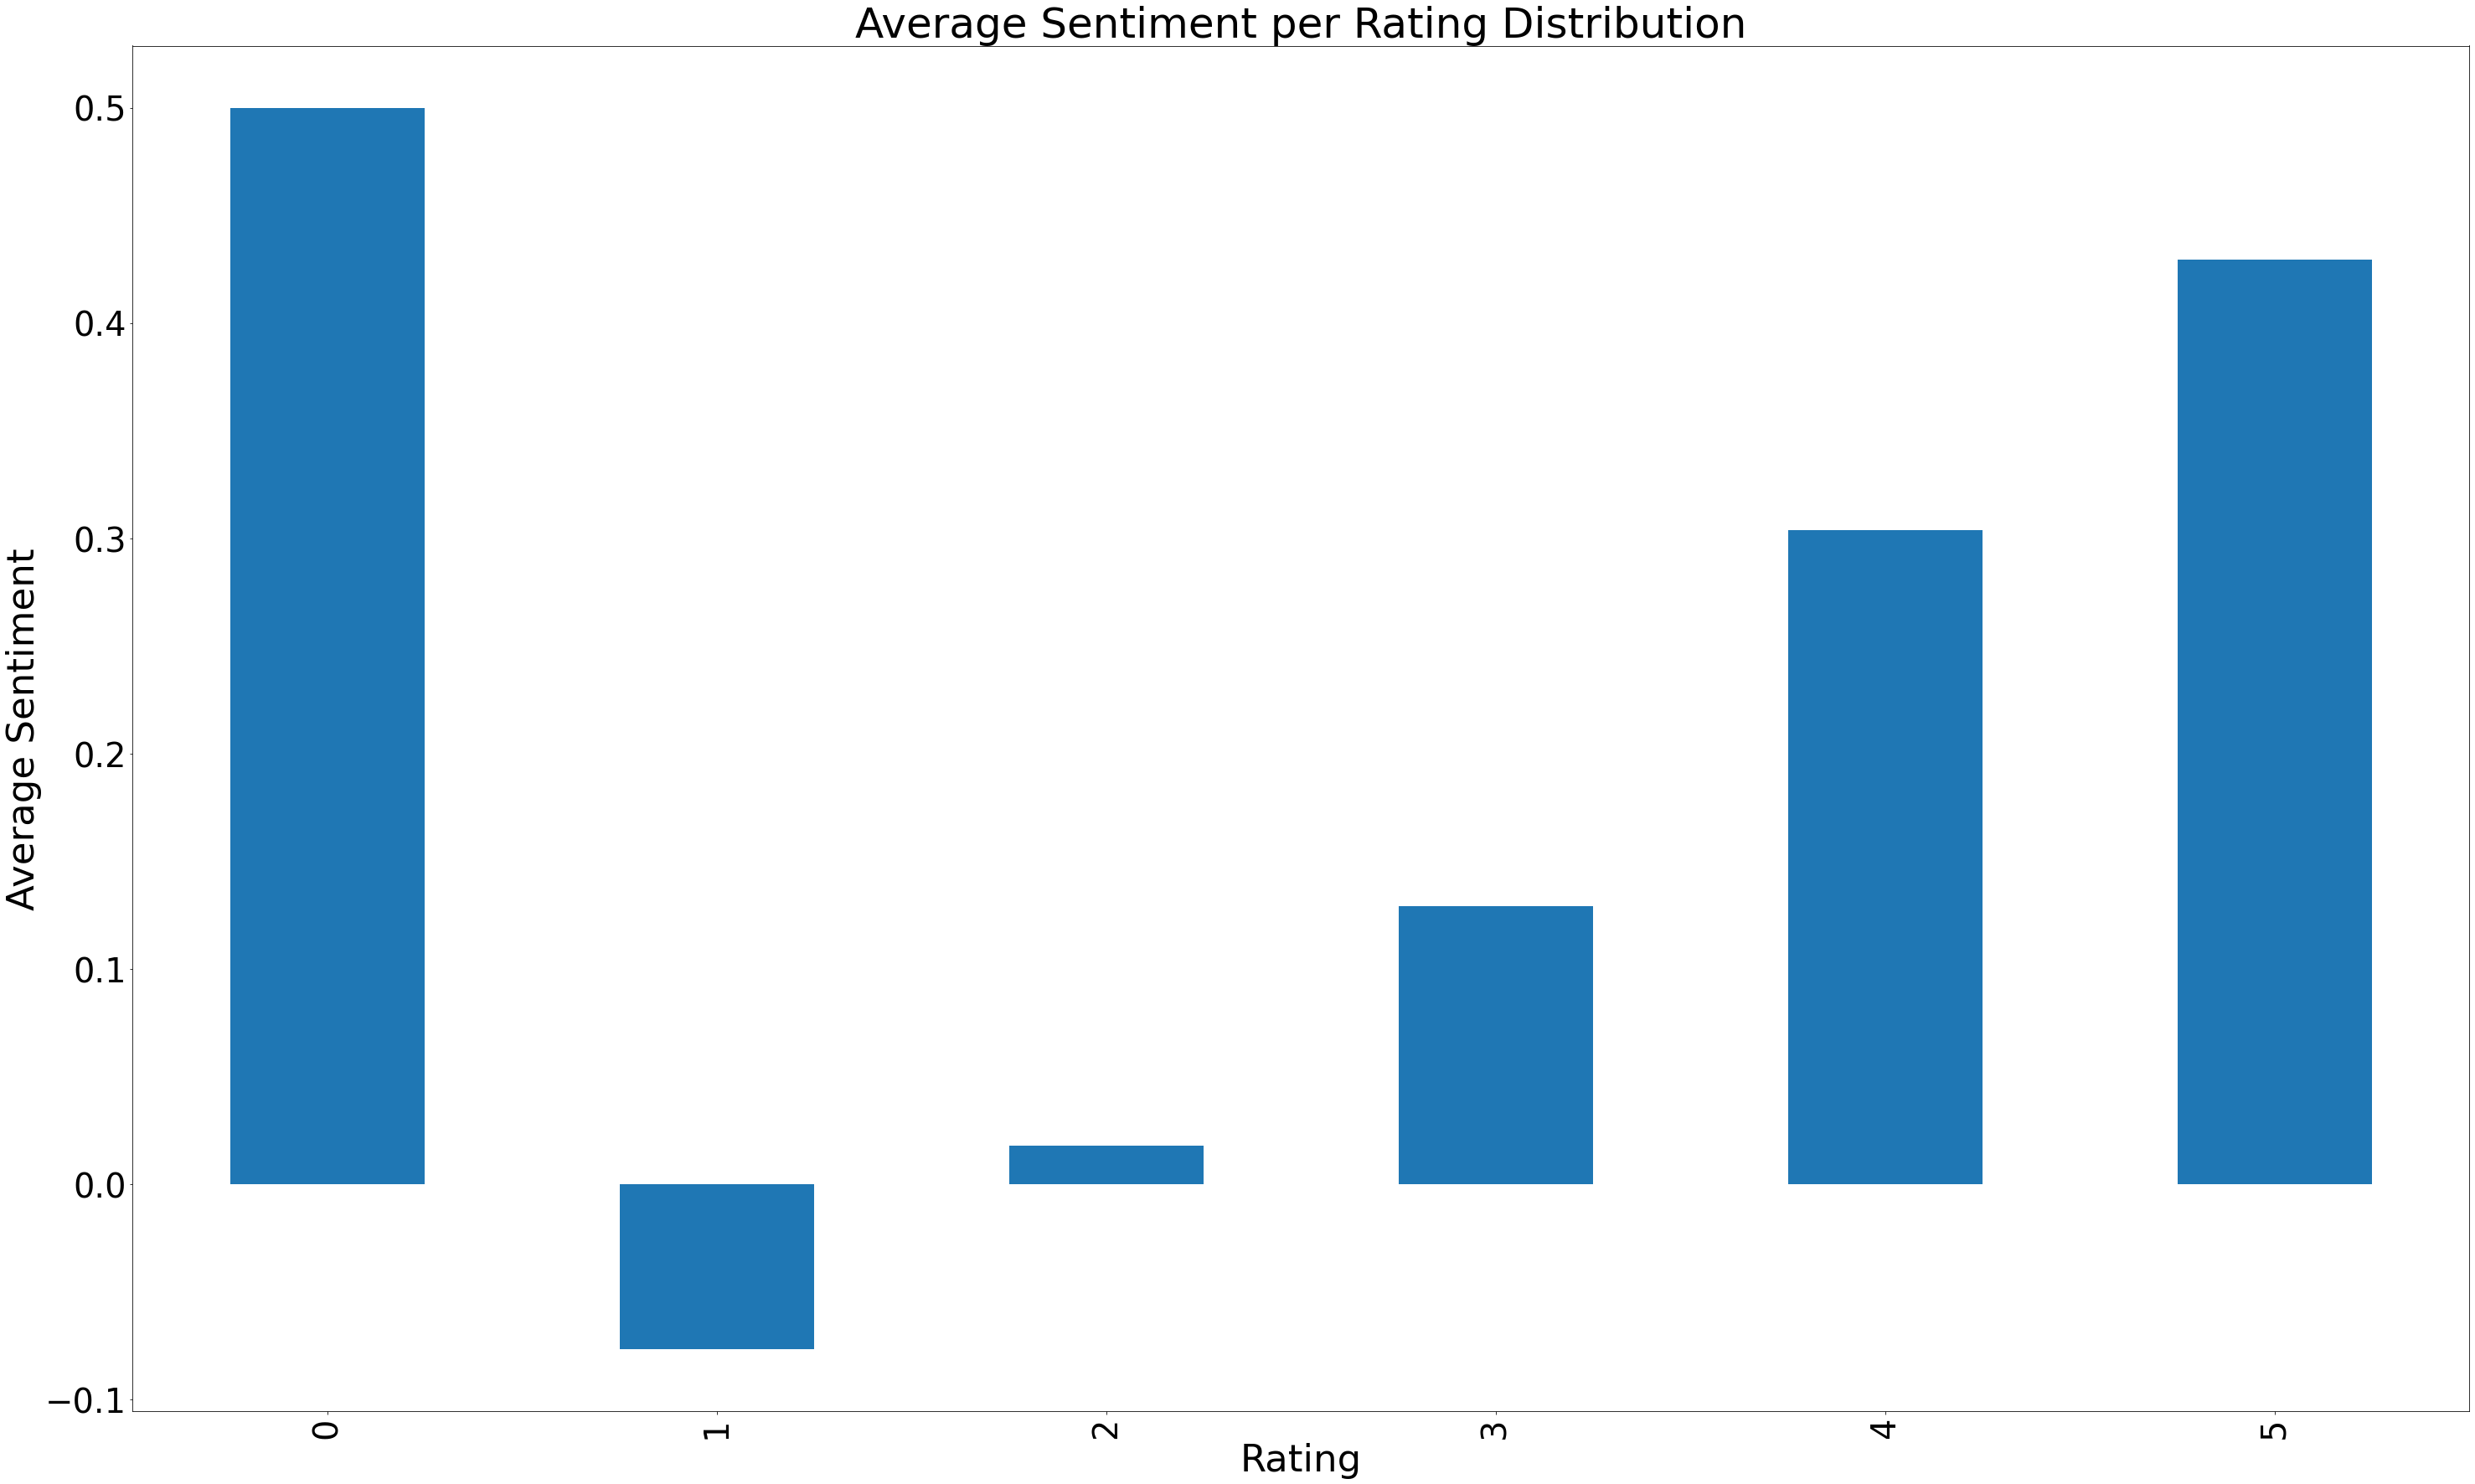

In [74]:
polarity_avg = df.groupby('score')['sentiment_stopwords'].mean().plot(kind='bar', figsize=(50,30))
plt.xlabel('Rating', fontsize=45)
plt.ylabel('Average Sentiment', fontsize=45)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.title('Average Sentiment per Rating Distribution', fontsize=50)
plt.show()

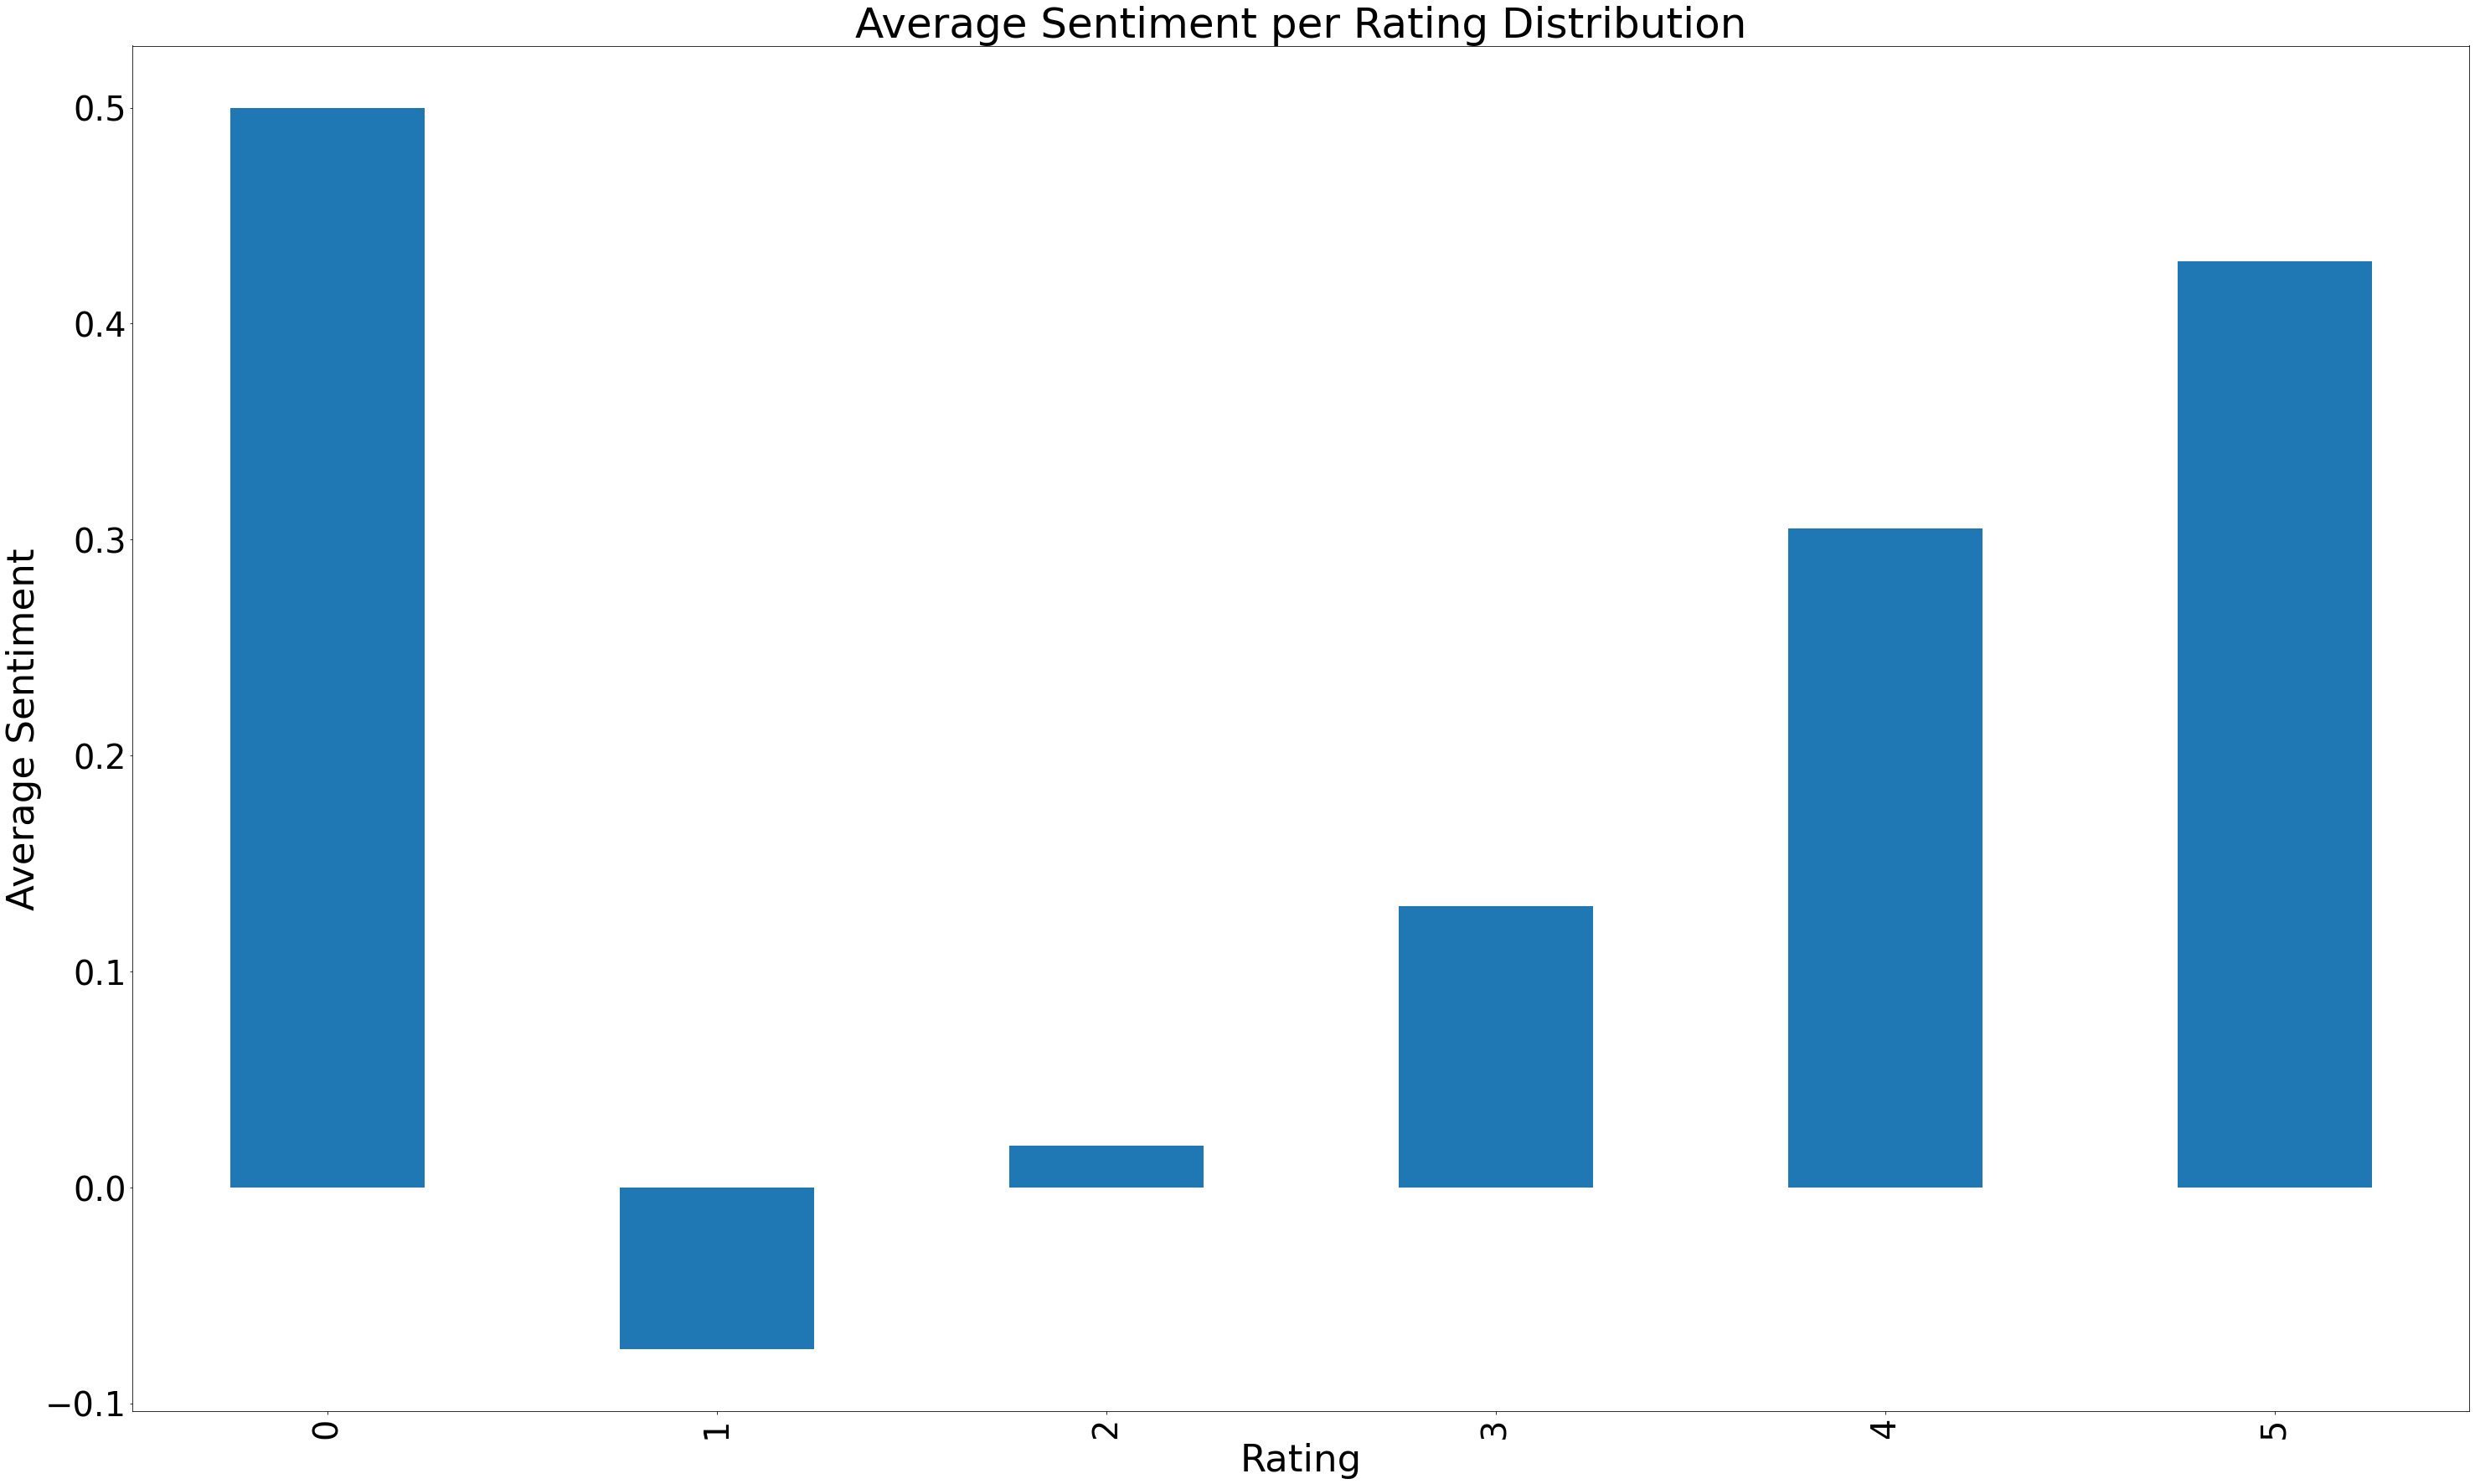

In [75]:
polarity_avg = df.groupby('score')['sentiment_without_stopwords'].mean().plot(kind='bar', figsize=(50,30))
plt.xlabel('Rating', fontsize=45)
plt.ylabel('Average Sentiment', fontsize=45)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.title('Average Sentiment per Rating Distribution', fontsize=50)
plt.show()

In [76]:
df['word_count'] = df['content_lemmatize'].apply(lambda x: len(str(x).split()))
df['review_len'] = df['content_lemmatize'].astype(str).apply(len)
df.head(5)

,reviewId,userImage,content,score,thumbsUpCount,at,content_words,content_sents,content_lemmatize,content_lemmatize_stopwords_remove,sentiment_stopwords,sentiment_without_stopwords,word_count,review_len
0,gp:AOqpTOG_9eJSnwoz0Kd8oTAk2zBntKZedjfWRP479-Ba8Les1Bx70PgMQ7RvOoTOgbjw8c4ywGocntM-uk3rUOU,https://play-lh.googleusercontent.com/a-/AOh14GiF2auY-cikDzkKQF2nH7zUmdF6rIsYeaNFvi2e,"Basically pay to win, except unless you belong to the top 10% of men, there's no winning.",1,0,2022-05-14 05:47:07,"[Basically, pay, to, win, except, unless, you, belong, to, the, top, 10, of, men, theres, no, wi...","[Basically pay to win, except unless you belong to the top 10% of men, there's no winning.]",Basically pay to win except unless you belong to the top 10 of men there no winning,Basically pay win except unless belong top 10 men there winning,0.350000,0.600,17,84
1,gp:AOqpTOFw2mikSa_YS9uowlzKwoVnBbvjhobWhe1E22492nvX2kIQQ2rIDkuSMqt6maZLbzcb5VOLfAGYnH6osis,https://play-lh.googleusercontent.com/a/AATXAJwnjFyqLofpbuk4mvVLtlZkf9dtM-YNr3zgLZzu=mo,Really good app find to someone,5,0,2022-05-14 05:44:17,"[Really, good, app, find, to, someone]",[Really good app find to someone],Really good app find to someone,Really good app find someone,0.700000,0.700,6,32
2,gp:AOqpTOFRFp5Elfb-L8NC4XBkCVN6hcoSJNhaBAnhaoRdoMZeHpIyst0fOlUNxr9RMCFk6HT3NbaqmP_SUA-MHN8,https://play-lh.googleusercontent.com/a-/AOh14Gh3ebCB57A8iHKlfz4YWPcLppRi66gnClHnG1OnxQ,Very good,5,0,2022-05-14 05:35:14,"[Very, good]",[Very good],Very good,Very good,0.910000,0.910,2,10
3,gp:AOqpTOHels3YsoDGgfRx1emFiJR_b45BFEJxl92qZ_NFinPHBolGOVrRKiuLCYlUlklGnYKETxs0OuMRr3fdlRU,https://play-lh.googleusercontent.com/a-/AOh14GhFjgkw2Qn7SqsIACNs55O995jrjjxzhjdTBkgfJ6I,Location location location,5,0,2022-05-14 05:33:55,"[Location, location, location]",[Location location location],Location location location,Location location location,0.000000,0.000,3,27
4,gp:AOqpTOHicyEpcA38nUuwlyP_QWYAdJbEwTxq7tzjrP0Givlxku96FNDOTvu2t8K9jpRRPIkB6Vk36dFbOeli0Iw,https://play-lh.googleusercontent.com/a/AATXAJzEWJXSEy6J0SK3DeHUxtpqR3Pr7FrHRITI_-Yv=mo,"Just made Tinder today, barely messaged people. Had no drama. Jumped on awhile later to see I ha...",1,0,2022-05-14 05:26:17,"[Just, made, Tinder, today, barely, messaged, people, Had, no, drama, Jumped, on, awhile, later,...","[Just made Tinder today, barely messaged people., Had no drama., Jumped on awhile later to see I...",Just made Tinder today barely messaged people Had no drama Jumped on awhile later to see I have...,Just made Tinder today barely messaged people Had drama Jumped awhile later see I banned Tinder...,0.016667,0.025,41,218


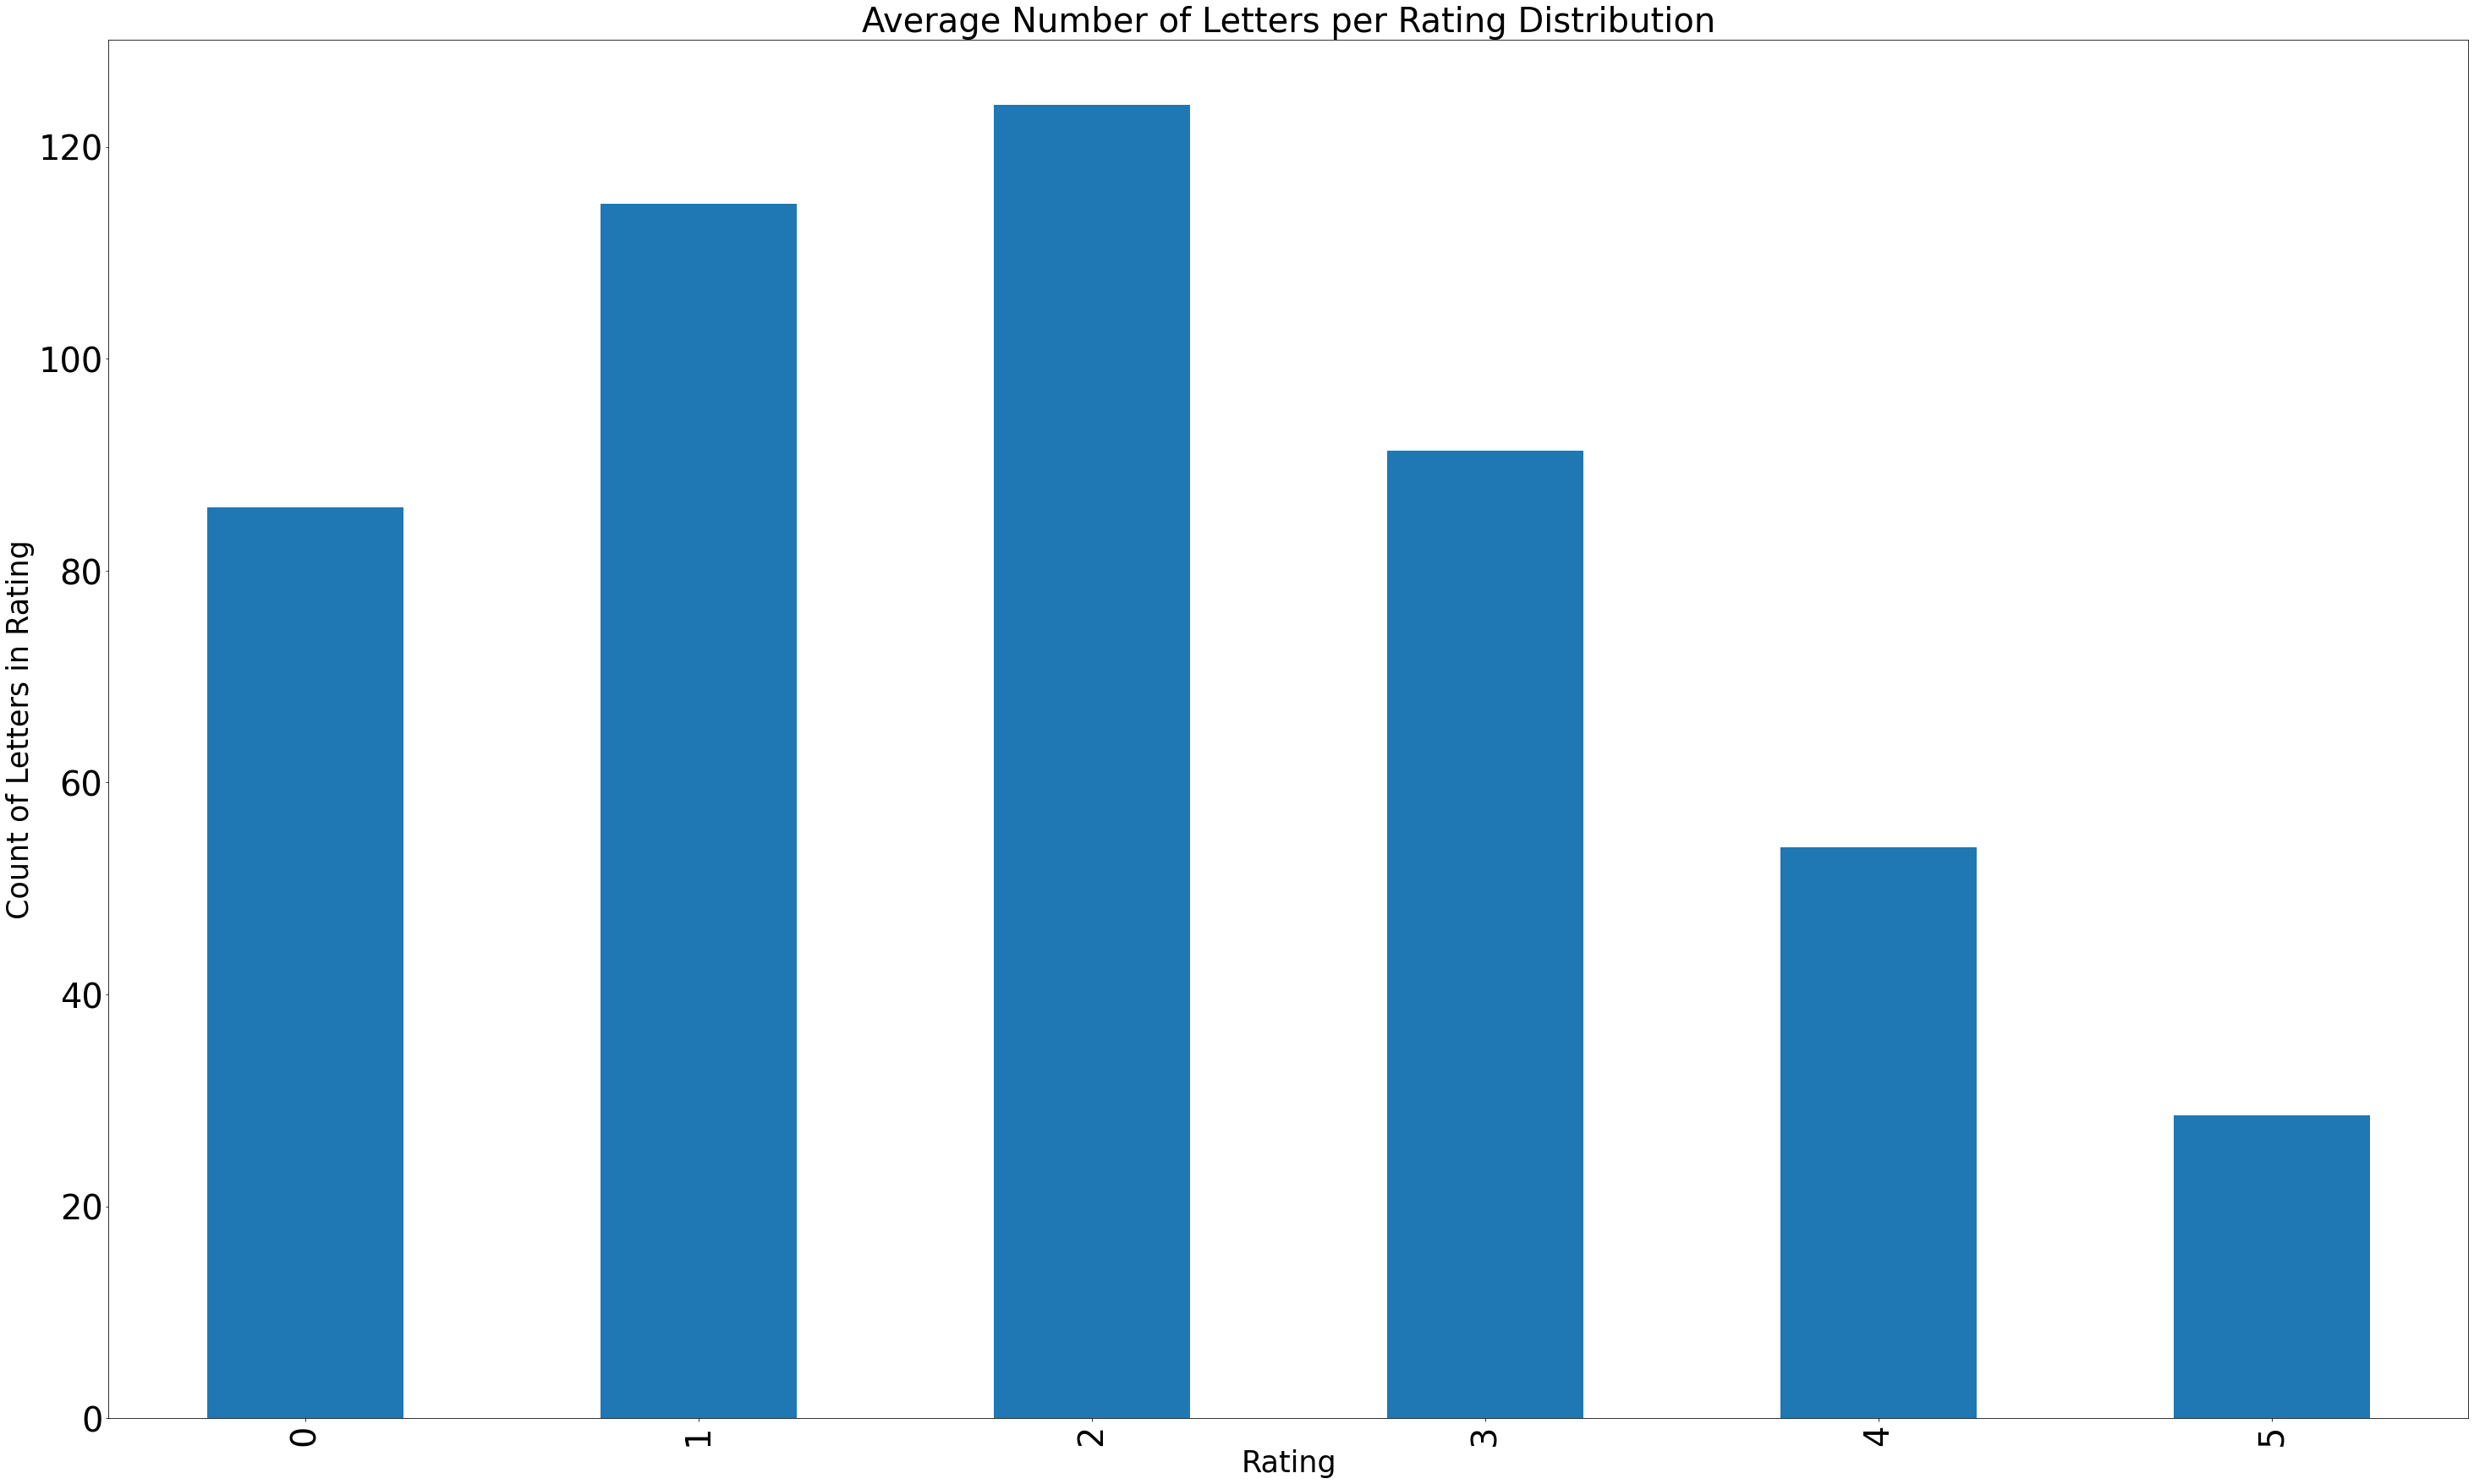

In [77]:
letter_avg = df.groupby('score')['review_len'].mean().plot(kind='bar', figsize=(50,30))
plt.xlabel('Rating', fontsize=35)
plt.ylabel('Count of Letters in Rating', fontsize=35)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.title('Average Number of Letters per Rating Distribution', fontsize=40)
plt.show()

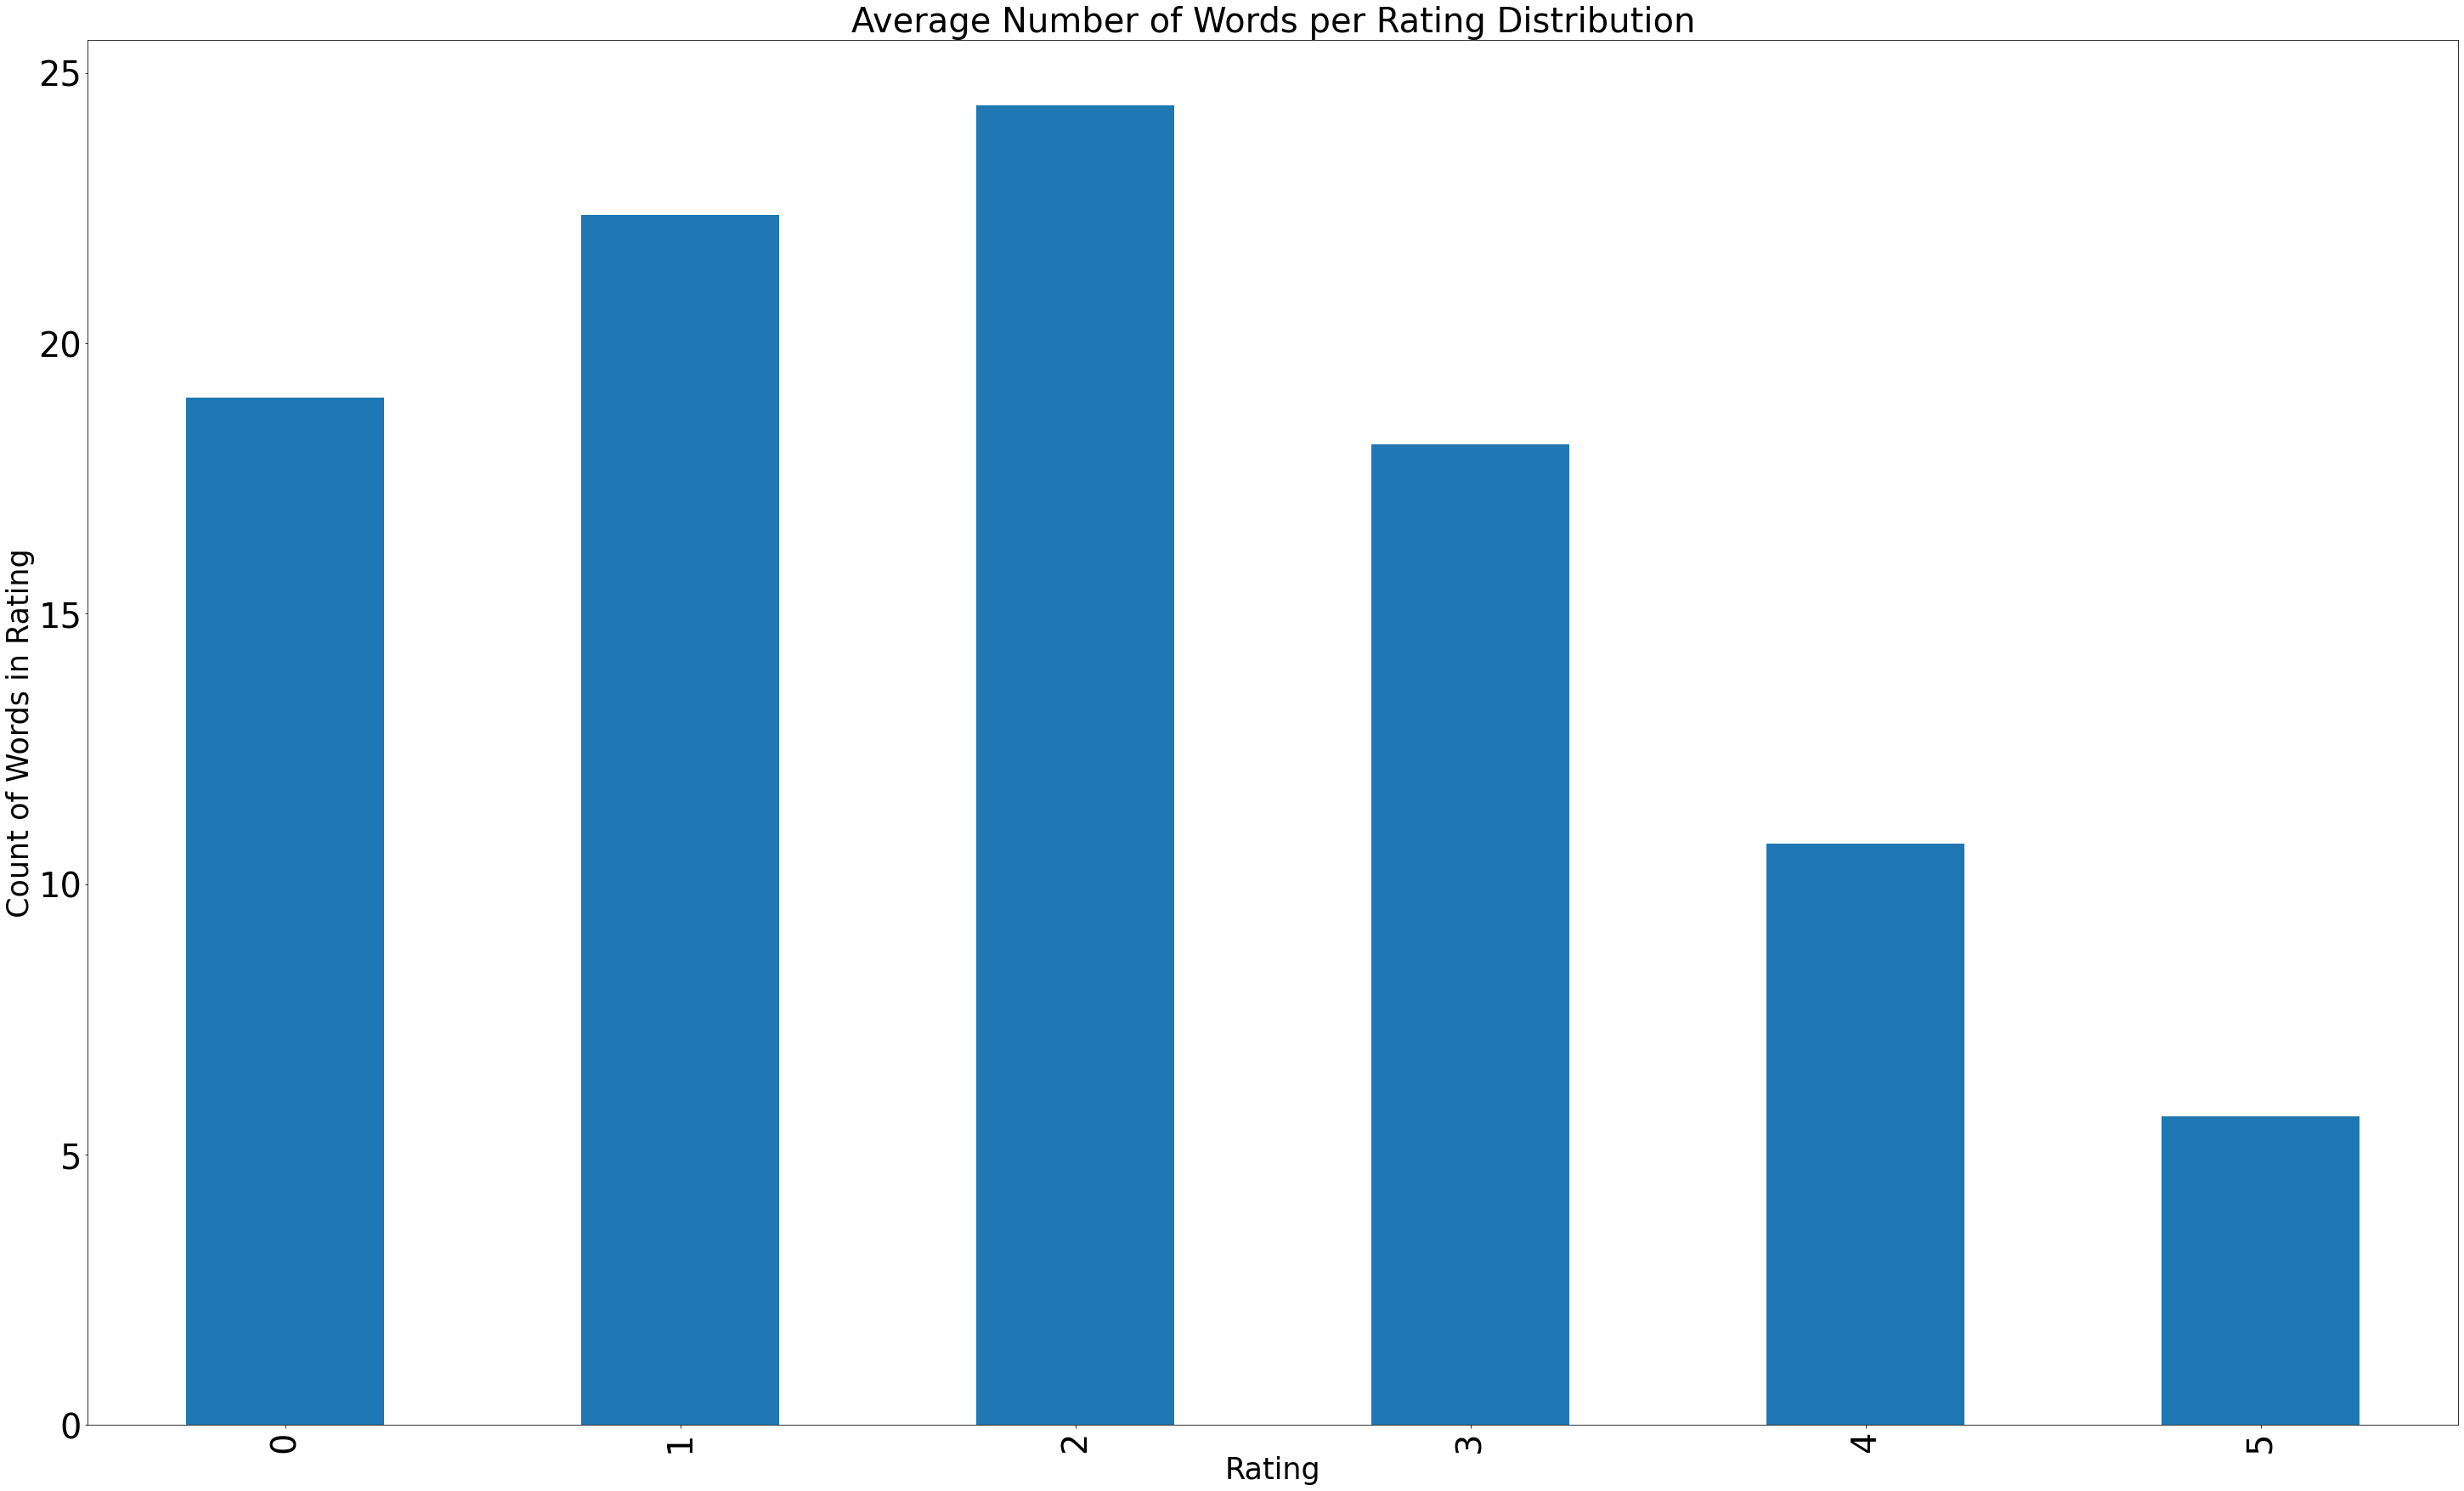

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


<AxesSubplot:>

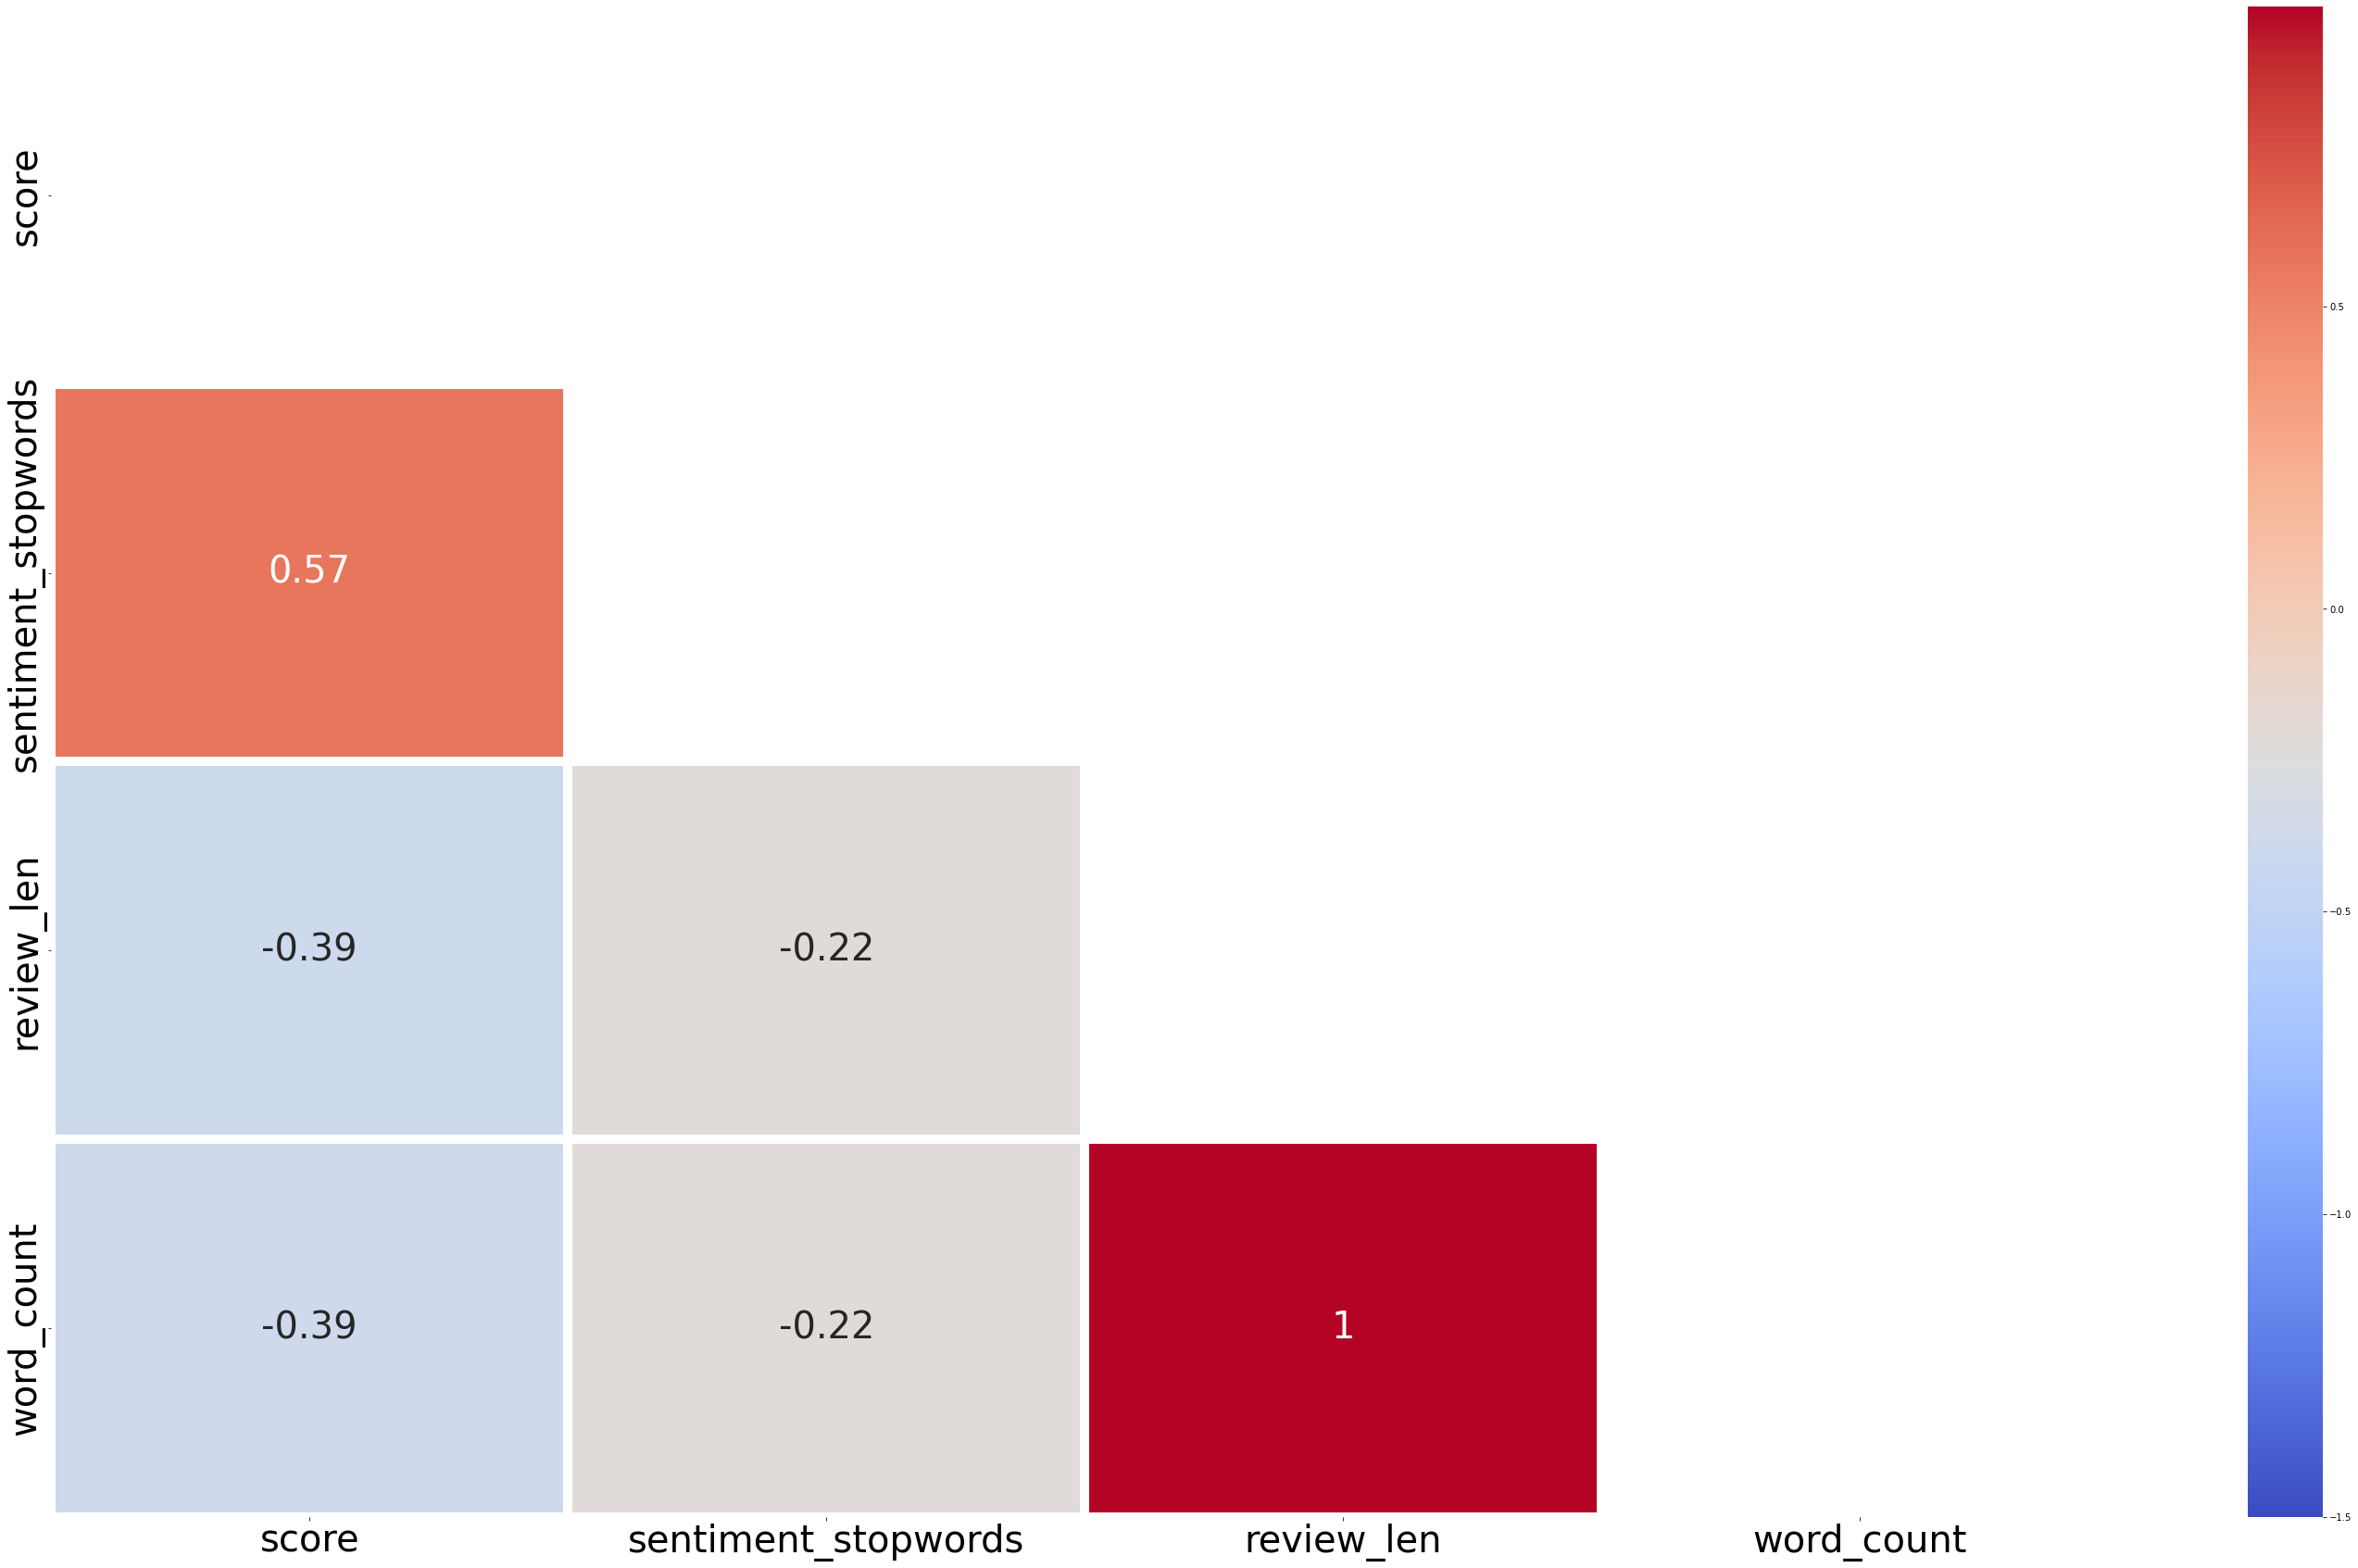

In [78]:
word_avg = df.groupby('score')['word_count'].mean().plot(kind='bar', figsize=(50,30))
plt.xlabel('Rating', fontsize=35)
plt.ylabel('Count of Words in Rating', fontsize=35)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.title('Average Number of Words per Rating Distribution', fontsize=40)
plt.show()

correlation = df[['score','sentiment_stopwords', 'review_len', 'word_count']].corr()
mask = np.zeros_like(correlation, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(50,30))
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
sns.heatmap(correlation, cmap='coolwarm', annot=True, annot_kws={"size": 40}, linewidths=10, vmin=-1.5, mask=mask)

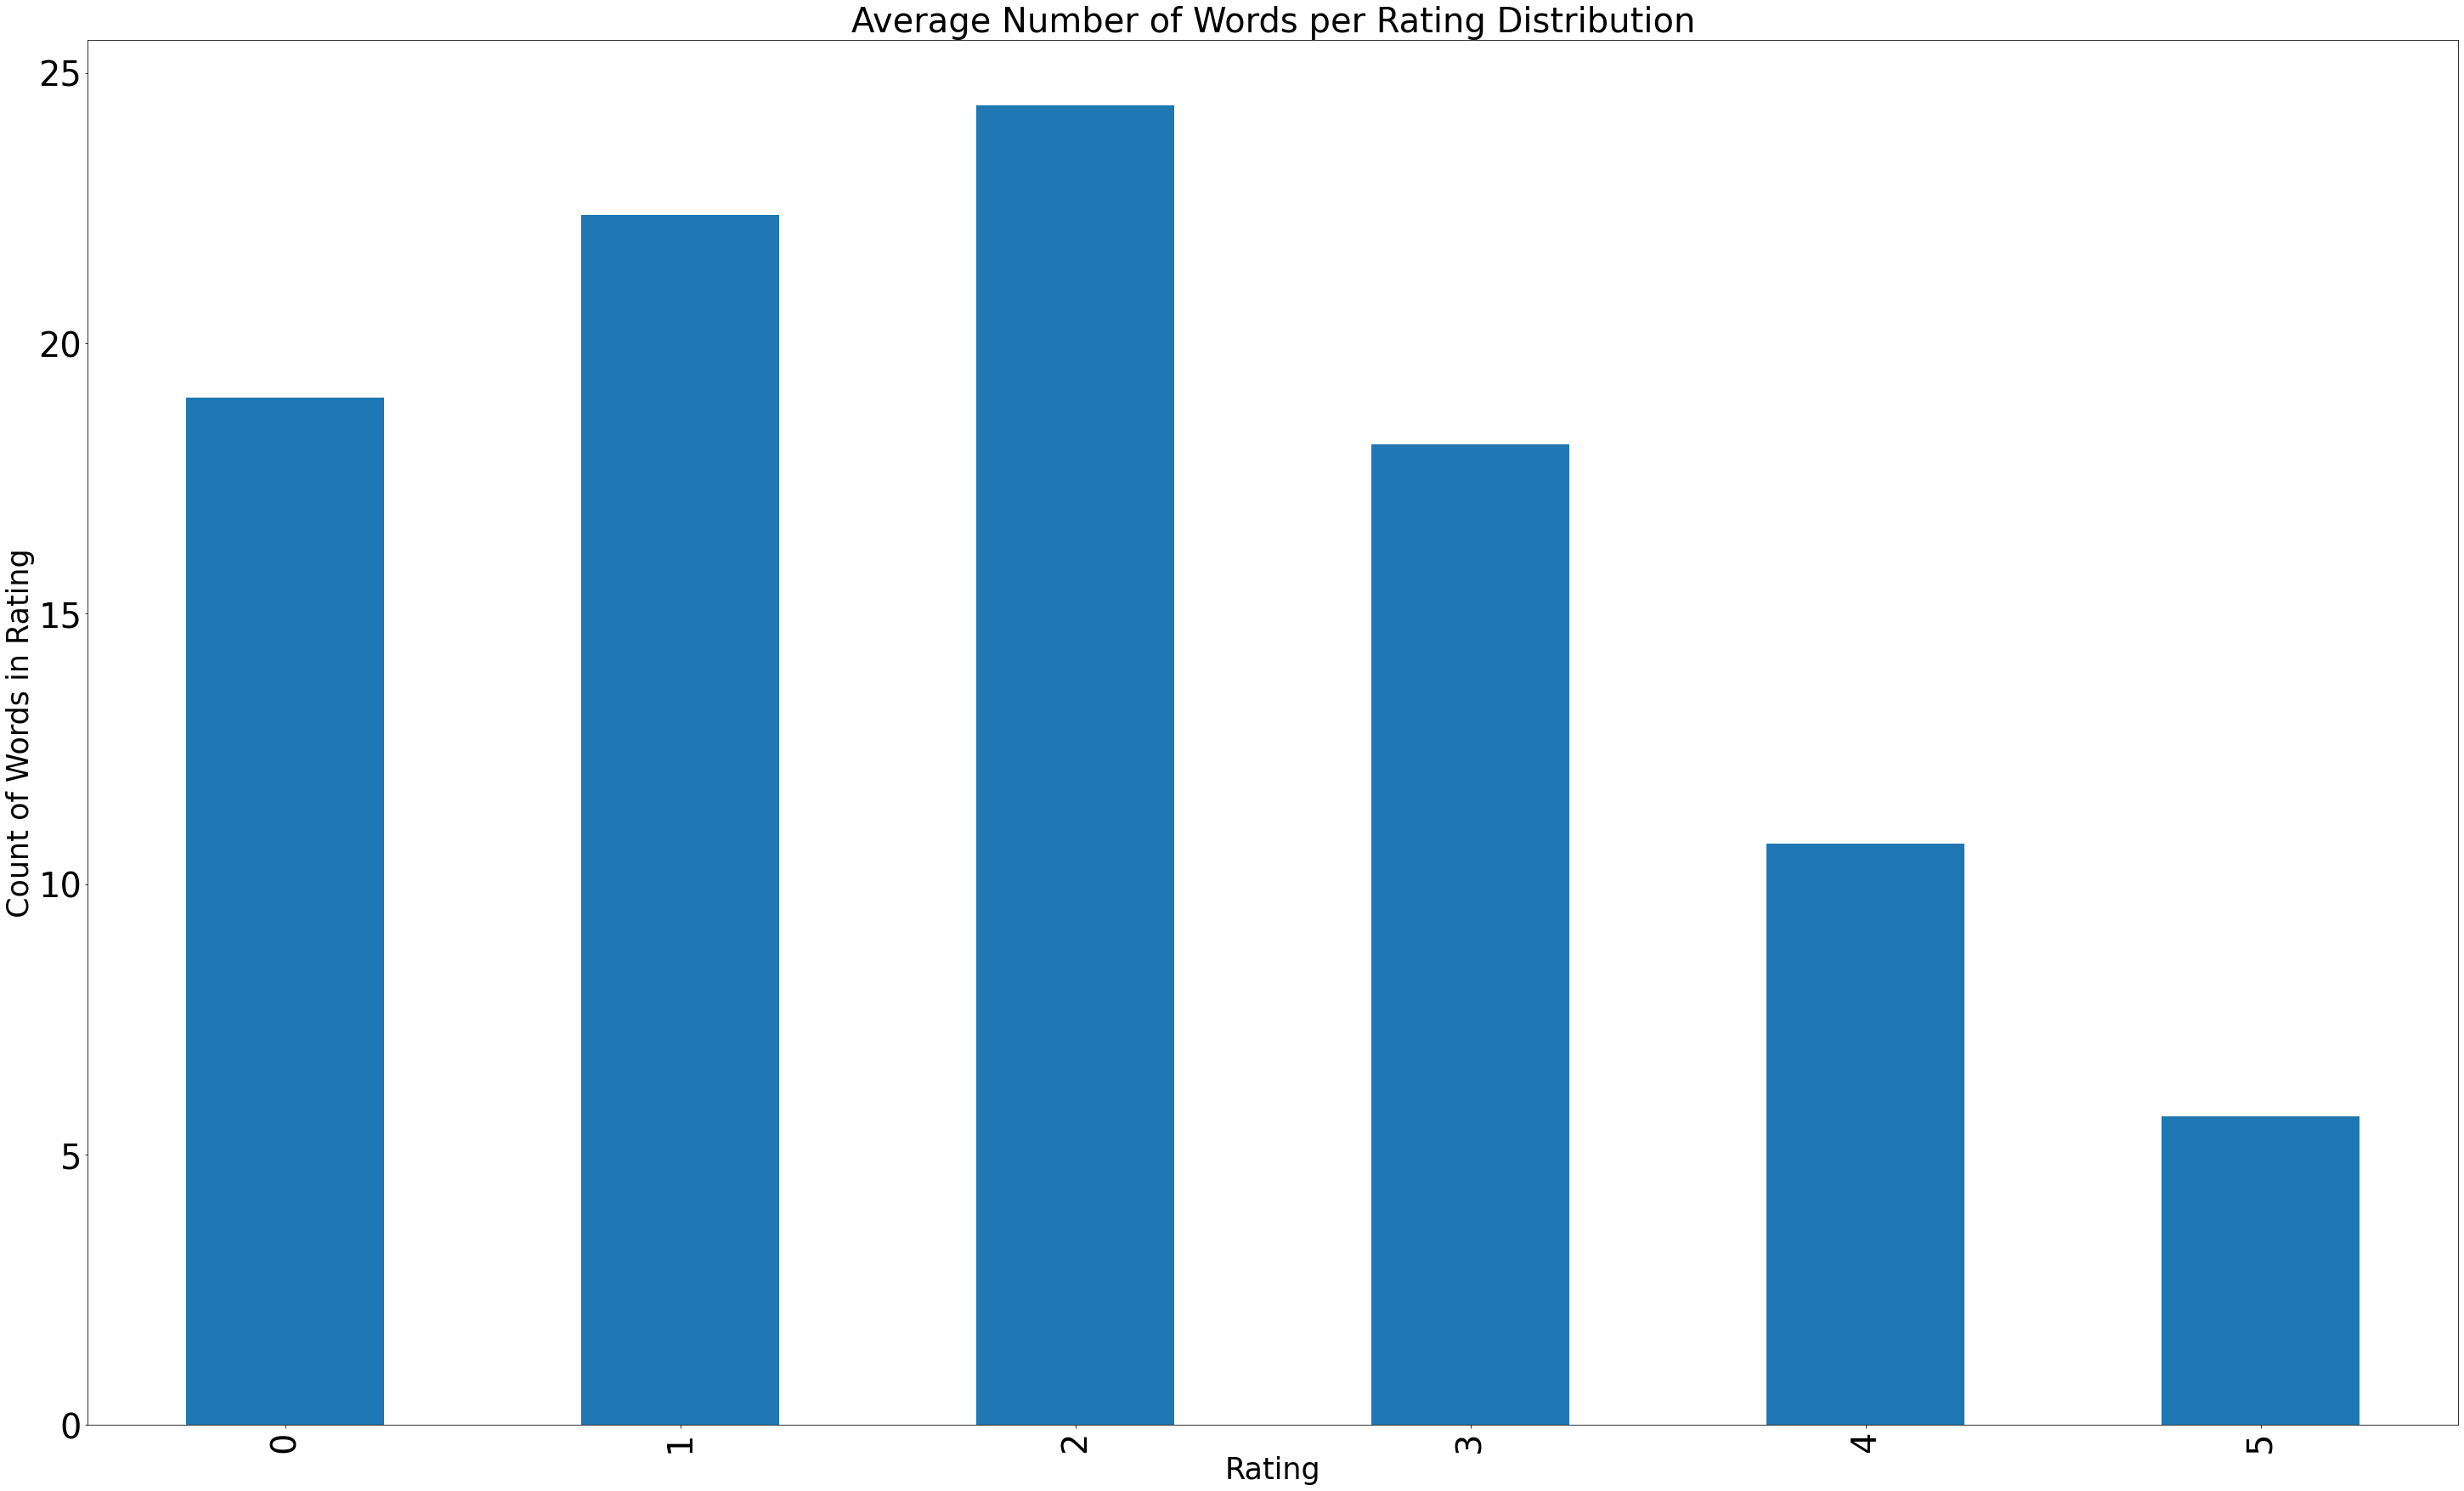

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


<AxesSubplot:>

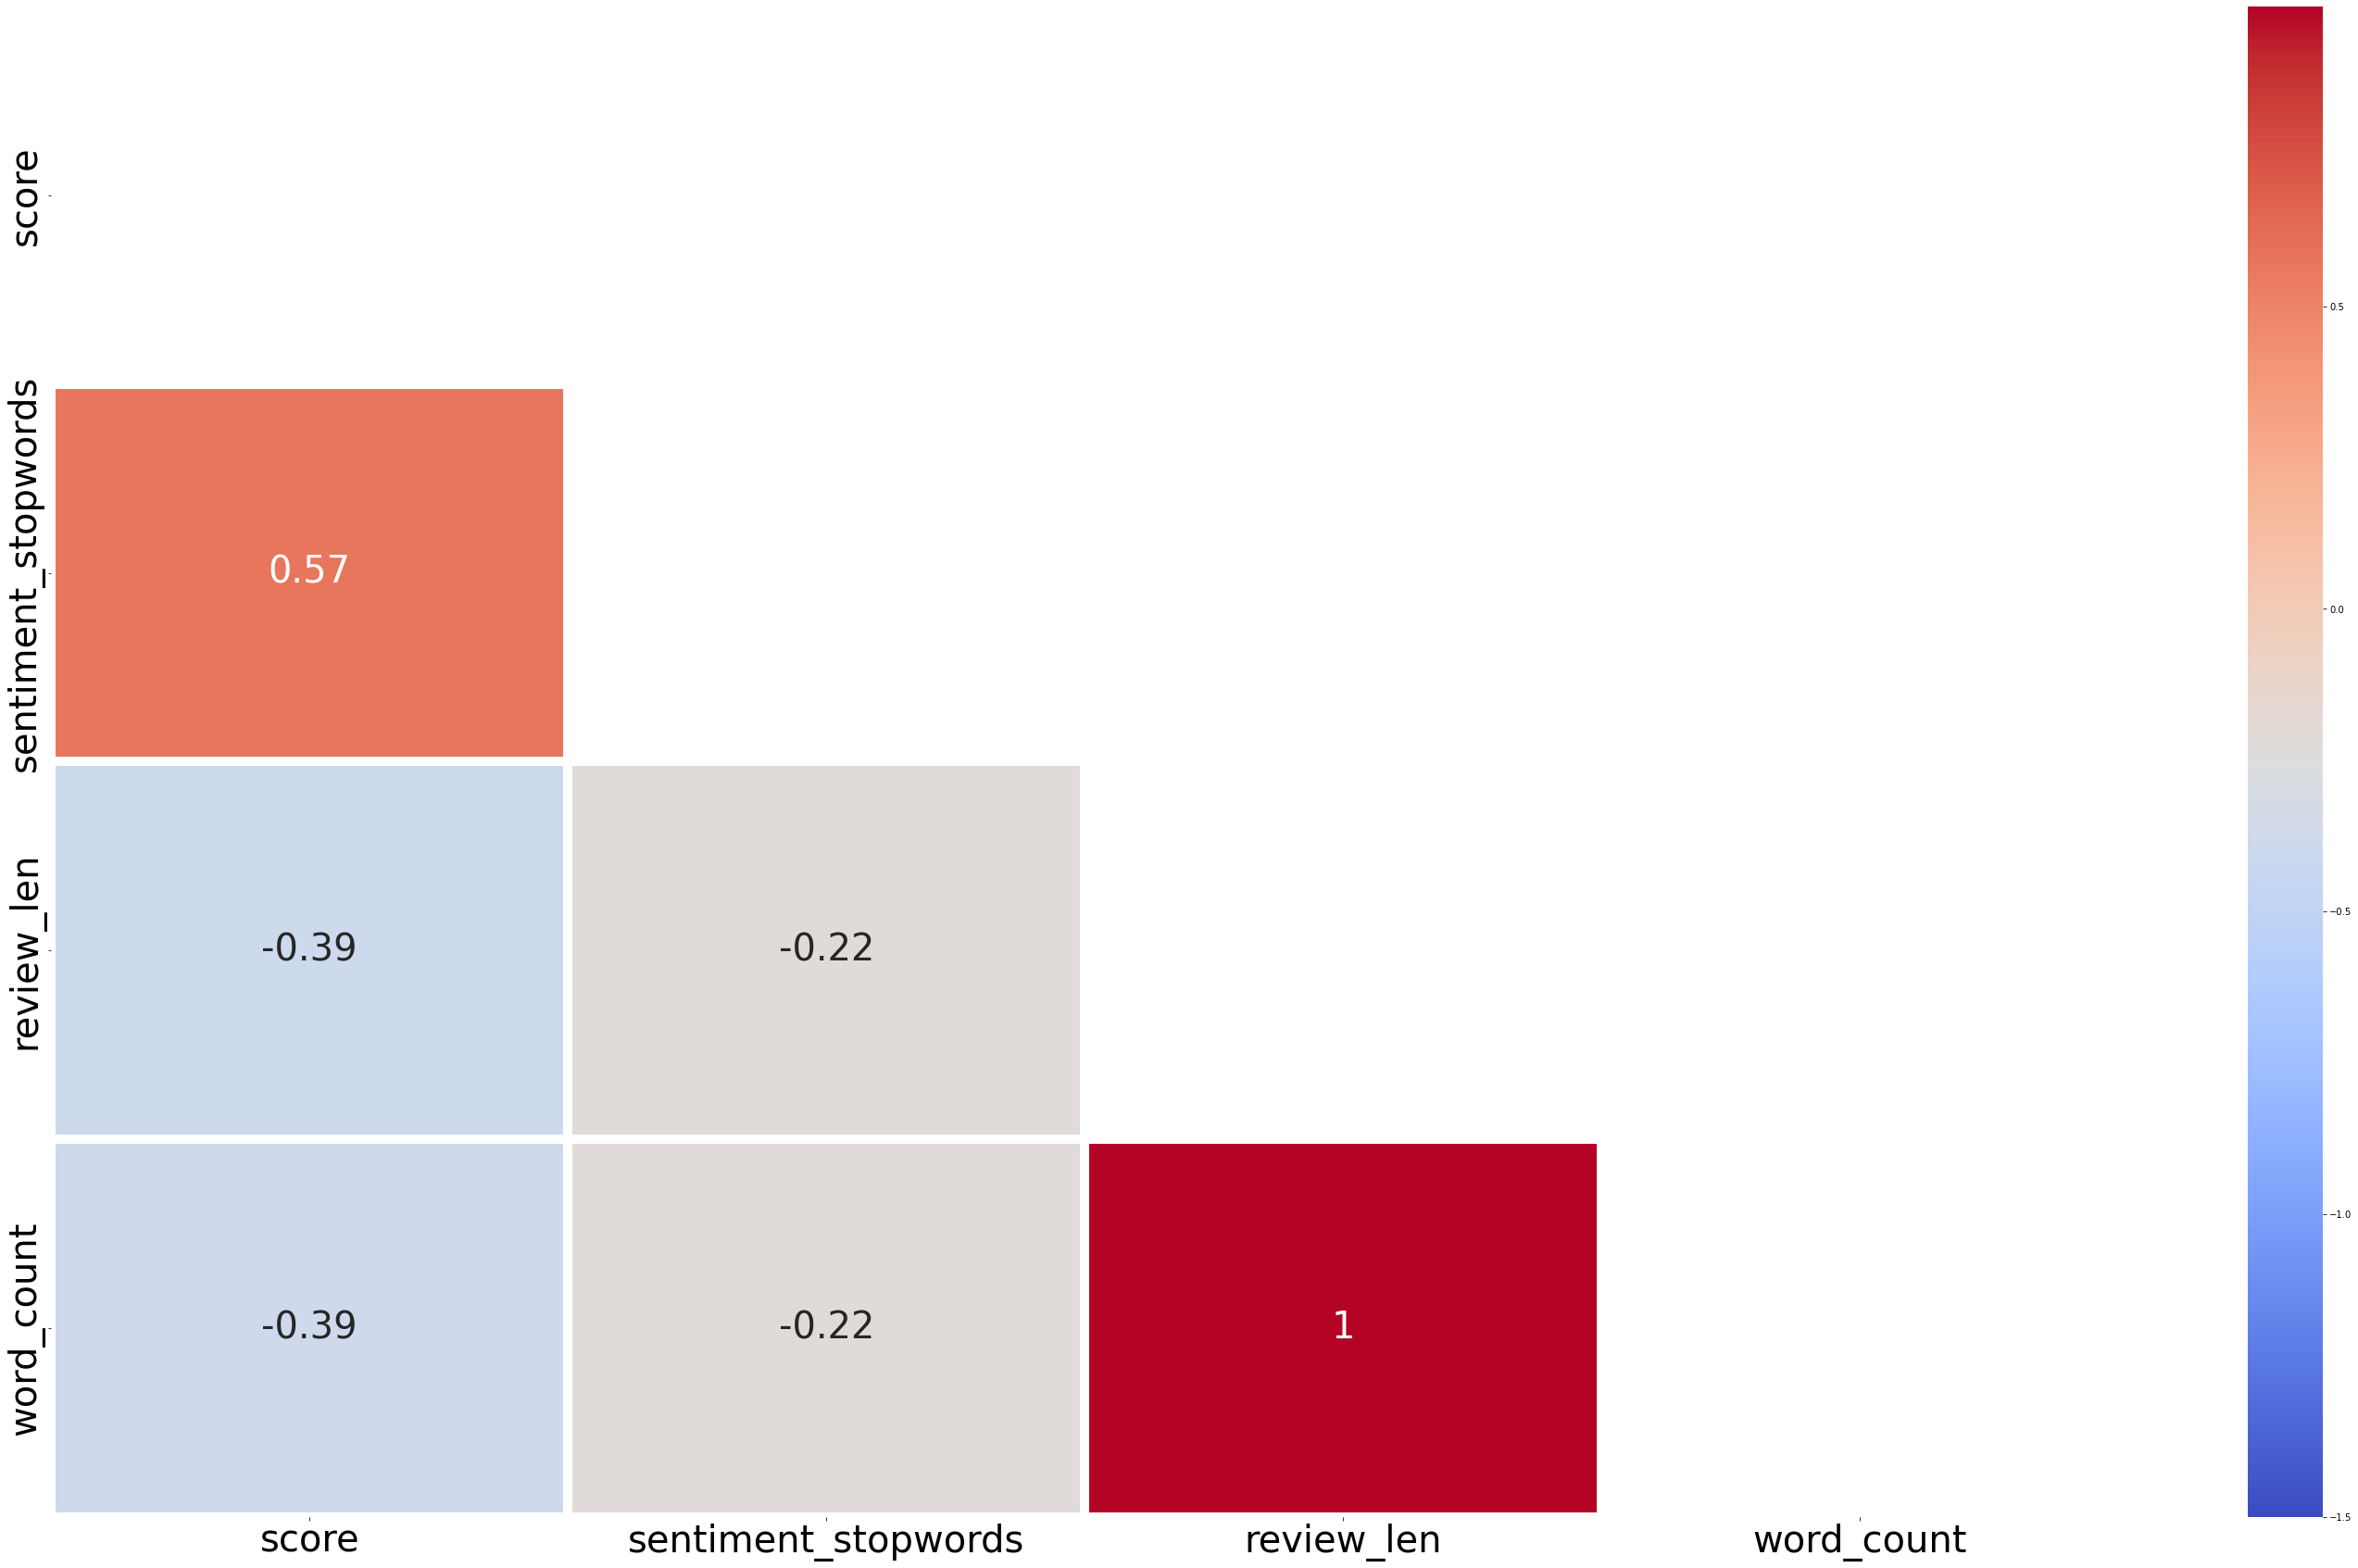

In [79]:
word_avg = df.groupby('score')['word_count'].mean().plot(kind='bar', figsize=(50,30))
plt.xlabel('Rating', fontsize=35)
plt.ylabel('Count of Words in Rating', fontsize=35)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.title('Average Number of Words per Rating Distribution', fontsize=40)
plt.show()

correlation = df[['score','sentiment_stopwords', 'review_len', 'word_count']].corr()
mask = np.zeros_like(correlation, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(50,30))
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
sns.heatmap(correlation, cmap='coolwarm', annot=True, annot_kws={"size": 40}, linewidths=10, vmin=-1.5, mask=mask)